<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 2
---------------------------------------------------------------
Student numbers: <span style="color:red">r0865274, r0869271, r0780597, r0786701, r0870499</span>.


In [1]:
import sys
import os
#old_stdout = sys.stdout            #code to prevent output
#sys.stdout = open(os.devnull, "w") #code to prevent output

#!pip install -U tensorflow==2.9.0
#!pip install -U keras==2.9.0
#!pip install keras-cv
!pip install segmentation-models

#sys.stdout = old_stdout            #code to prevent output

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 775.7 kB/s eta 0:00:00a 0:00:01


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import seaborn as sns
import pathlib
import pickle


#import keras_cv
from sklearn.model_selection import train_test_split
import cv2
from keras_tuner import HyperParameters as hp
import keras_tuner as kt

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import multilabel_confusion_matrix
plt.set_cmap('gist_rainbow')

<Figure size 432x288 with 0 Axes>

# Data loading and initial inspection

We first load the data and make an initial inspection

In [3]:
train_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/train_set.csv', index_col="Id")
labels = train_df.columns
train_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/img/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
train_df["seg"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/seg/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
print("The training set contains {} examples.".format(len(train_df)))

labels = list( train_df.columns[0:-2] )

The training set contains 749 examples.


In [4]:
img_sizes = np.array([r['img'].shape for i,r in train_df.iterrows()])
minx = np.argmin(img_sizes[:,0])
miny = np.argmin(img_sizes[:,1])
maxx = np.argmax(img_sizes[:,0])
maxy = np.argmax(img_sizes[:,1])
print('Smallest images')
print([img_sizes[minx],img_sizes[miny]])
print('Largest images')
print([img_sizes[maxx],img_sizes[maxy]])

Smallest images
[array([112, 500,   3]), array([198, 257,   3])]
Largest images
[array([500, 332,   3]), array([333, 500,   3])]


Looking at the frequency of labels in the provided training data, we can see that the clases are mostly evenly distributed. With the exception of the *person* class which is present in more than 25% of images. This can be attributed to 

In [5]:
yCat = train_df.drop(labels=['img','seg'],axis=1)
dtrain = 100*yCat.sum()/yCat.shape[0]
dtrain = pd.DataFrame({'Freq':dtrain})
pd.options.display.float_format = '{:,.2f}'.format
dtrain

Freq
aeroplane    6.28
bicycle      5.21
bird         7.34
boat         6.41
bottle       5.61
bus          5.07
car          8.41
cat          6.01
chair        9.21
cow          4.01
diningtable  6.41
dog          5.74
horse        5.61
motorbike    6.28
person      27.64
pottedplant  5.74
sheep        3.60
sofa         5.87
train        5.34
tvmonitor    6.81

# Train / Test / Validation Split

Split the data into train, test and validation data.
* Train is used for model fitting
* Test is used for model testing, we will inspect on this data.
* Validation is used for early stopping of model fitting to prevent over-fitting.


We create two sets of data for training:
* For model fitting and testing we use just the training data. This will give us an idea of the performance of the model.
* For the final model training we will also fit on the training+test data, we will make our final prediction using this data set.

Both sets are futher augmented.

We still keep the validation set seperate, to prevent overfitting of our data.

Here we use a 60/20/20 split and we fix the seeds for repeatablilty.
The performance of the final network on the submission data will be dependent on exactly this split takes place. For example, if more *useful* data for the generalisation of the network placed in the training set. This could have been improved through a cross-fold validation, but we didn't have computational capacity to perform this.

In [6]:
# Split off the test_data  and the train_data.
train_data, test_data = train_test_split(train_df,test_size = 0.2,shuffle=True,random_state = 0)
# Split 25% off the train data to use as validation (0.25 x 0.8 = 0.2)
train_data, val_data = train_test_split(train_data,test_size = 0.25,shuffle=True,random_state = 1)
print(f" Ntrain {len(train_data.index)}")
print(f" Ntest  {len(test_data.index)}")
print(f" Nval   {len(val_data.index)}")

 Ntrain 449
 Ntest  150
 Nval   150


After train/test/validation split the labels are approximately equal in all sets. A further improvement would be to use a multi-label stratification for this part

In [7]:
yCat_train = train_data.drop(labels=['img','seg'],axis=1 )
yCat_test  = test_data.drop(labels=['img','seg'],axis=1 )
yCat_val   = val_data.drop(labels=['img','seg'],axis=1 )

dtrain = 100*yCat_train.sum()/yCat_train.shape[0]
dtest  = 100*yCat_test.sum()/yCat_test.shape[0]
dval   = 100*yCat_val.sum()/yCat_val.shape[0]

dist = pd.concat([dtrain,dtest,dval],axis=1)
dist.columns=(["Train","Test","Val"])
dist

Train  Test   Val
aeroplane     5.79  4.67  9.33
bicycle       5.12  6.00  4.67
bird          8.24  6.67  5.33
boat          6.01  8.00  6.00
bottle        5.12  4.67  8.00
bus           4.90  2.67  8.00
car          10.24  6.00  5.33
cat           5.57  8.00  5.33
chair         7.80 15.33  7.33
cow           4.23  3.33  4.00
diningtable   5.79  8.00  6.67
dog           5.79  6.67  4.67
horse         6.01  3.33  6.67
motorbike     6.24  6.00  6.67
person       28.73 25.33 26.67
pottedplant   6.01  4.67  6.00
sheep         3.79  3.33  3.33
sofa          4.68  6.00  9.33
train         5.57  6.00  4.00
tvmonitor     5.12 14.00  4.67

# Resizing and Data augmentation

Deep neural networks are prone to over-fitting, unless provided with a large amount of training data. Data augmentation is a way of working around this problem, by creating new training images through manipulations of the original ones. For example if examples of busses of our training data was dominated by red busses photographed full frame, we may have difficulty recognising a blue bus photographed from a distance.

In this case we have relatively few examples to train with (449), and it is clear that we should perform some augmentation first. This was also seen during our investigation of the networks.


This is very rich field of study and their are numerous possibilities to explore. [Shorten, C., & Khoshgoftaar, T. M. (2019). A survey on image data augmentation for deep learning. Journal of big data, 6(1), 1-48.](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0197-0), these include:

* Geometric transformations: Flipping, rotating, translating, zooming and cropping.
* Color space transformation: Colour space alterations, brightening darkening. To account for variations in the colours of the objects.
* Kernel filters: Applying blurring / sharpening transformations. To account for different conditions under which the photograph might be taken.
* Random erasing: Randomly erasing (replace with a constant or noise) parts of the image, in order to learn more robust features. For example enabling detection of person from just their head without their body being visible [Zhong, Z., Zheng, L., Kang, G., Li, S., & Yang, Y. (2020, April). Random erasing data augmentation. In Proceedings of the AAAI conference on artificial intelligence (Vol. 34, No. 07, pp. 13001-13008).](https://arxiv.org/abs/1708.04896)
* Mixing images: Combinging different images into one image. Their are two main ways this can be accomplished, pairing samples of compositing of images. In [Data Augmentation by Pairing Samples for Images Classification](https://arxiv.org/abs/1801.02929) are overlayed over each other. With RICAP (Random Image Cropping and PatchingAdditionally) rectangular patches of different images can be composited together into one image) [Takahashi, R., Matsubara, T., & Uehara, K. (2019). Data augmentation using random image cropping and patching for deep CNNs. IEEE Transactions on Circuits and Systems for Video Technology, 30(9), 2917-2931.](https://arxiv.org/pdf/1811.09030.pdf). Both these techniques. can be performed *across classes* i.e. combing images of busses and of people.

In [Taylor, L., & Nitschke, G. (2018, November). Improving deep learning with generic data augmentation. In 2018 IEEE Symposium Series on Computational Intelligence (SSCI) (pp. 1542-1547). IEEE.](https://arxiv.org/pdf/1708.06020.pdf) it was shown that *flipping*, *rotating*, *cropping/zooming* and *color augmentations* delivered significant in the performance of the network on the Caltech 101 dataset.

Both the With the *mixing images*, and *random erasing technique* have a tendency to massively increase the amount of data and we are working with limited resources. Additionally with the random erasing technique there is a lot of freedom as to how much of the image to erase, what to replace it with (noise or constant), and label preservation. For these reasons in this work we concentrate of geometric and color space transformations.

We apply the following transformations to the images and segmentation masks, randomly:
* Horizontal flips: An object can be photographed from either side.
* Translations: An object may be appear anywhere in the frame
* Rotations: Small variations in the orientations of the objects may appear.
* Zooms: Both in and out, to account for variations in scale.
* Brighten: Darkening or brightening of the images. Images may be taken under different lighting conditions.
* Hue adjustments: To account for changes in the colour of an object, for an example cars can have many different colours.

Care must be taken over the following things:
* Applying the same adjustment to both the image and segmentation masks, in the same order (except brighten and hue).
* When zooming or rotating objects are the edge may leave the frame.
* We use bilinear interpolation on the images to interpolate between pixels, and nearest neighbour interpolation on the segmentation masks. We do nearest neighbour interpolation on the segmentation masks so that we don't have an *intermediate* class at the boundary of the images.
* When translating, rotating and zooming, data needs to be filled in. We use the mode *reflect* as opposed to *wrap* so that images are reflected around the boundary. This stops objects from appearing on 

The class **Augment** below takes care of performing these transformation.

Our training sets consist of the *original* data + 9 sets of the *augmented* data.

The augmentations are not applied in this notebook but are instead applied elsewhere and stored.

In [8]:
IMG_SIZE = 256

In [9]:
class Augment(keras.layers.Layer):
    def __init__(self,seed = 42):
        super().__init__()
        
        # Make sure to give the same seed for both layers, so we apply the same transformation to the image and the mask
        self.flip_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.flip_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        seed += 1 #Increment the seed each time, we don't want the flips and rotations to be correlated by accident.

        rotangle  = 20 #Rotate by plus or minus 20 degrees
        rotfactor = rotangle/360
        self.translate_inputs = tf.keras.layers.RandomTranslation(0.2,0.2,
                                                                 fill_mode='reflect',
                                                                 interpolation='bilinear',
                                                                 seed=seed)
        
        self.translate_labels = tf.keras.layers.RandomTranslation(0.2,0.2,
                                                                 fill_mode='reflect',
                                                                 interpolation='nearest',
                                                                 seed=seed)
        
        seed+=1
        self.rotate_inputs = tf.keras.layers.RandomRotation(rotfactor,
                                                            fill_mode='reflect',
                                                            interpolation='bilinear',
                                                            seed=seed)
        
        self.rotate_labels = tf.keras.layers.RandomRotation(rotfactor,
                                                            fill_mode='reflect',
                                                            interpolation='nearest',
                                                            seed=seed)
        
        seed +=1
        self.zoom_inputs = tf.keras.layers.RandomZoom(height_factor=(-0.2, +0.2),
                                                            fill_mode='reflect',
                                                            interpolation='bilinear',
                                                            seed=seed)
        self.zoom_labels = tf.keras.layers.RandomZoom(height_factor=(-0.2, +0.2),
                                                            fill_mode='reflect',
                                                            interpolation='nearest',
                                                            seed=seed
                                                             )
        seed += 1
        self.brighten_inputs = tf.keras.layers.RandomBrightness(factor=(0.2),seed=seed)
        
        seed +=1
        self.hueadjust = keras_cv.layers.RandomHue(factor=0.2,value_range=[0,255],seed=seed)
        
    def call(self, inputs, labels):
        labels = np.atleast_3d(labels)
        
        inputs = self.translate_inputs(inputs)
        labels = self.translate_labels(labels)
        
        inputs = self.flip_inputs(inputs)
        labels = self.flip_labels(labels)

        inputs = self.rotate_inputs(inputs)
        labels = self.rotate_labels(labels)

        inputs = self.zoom_inputs(inputs)
        labels = self.zoom_labels(labels)
        
        inputs = self.brighten_inputs(inputs)
        inputs = self.hueadjust(inputs)
        
        inputs = np.array( inputs ).astype(np.uint8)
        labels = np.array( labels ).astype(np.uint8)
        return inputs, labels

## Inspecting the augmentations

In [10]:
Ximg_aug1 = np.load(f"/kaggle/input/data-augmentation-v3/{IMG_SIZE}/aug1/Ximg.npy",mmap_mode='r')
ySeg_aug1 = np.load(f"/kaggle/input/data-augmentation-v3/{IMG_SIZE}/aug1/ySeg.npy",mmap_mode='r')
Ximg_train1 = np.load(f"/kaggle/input/data-augmentation-v3/{IMG_SIZE}/train/Ximg.npy",mmap_mode='r')

First lets look at some images which have been augmented to check that we have indeed applied the augmentations to images and segmentation masks correctly.

* 1st row: Unaugmented images
* 2nd row: Augmented images
* 3rd row: Augmented segmentation masks

<Figure size 432x288 with 0 Axes>

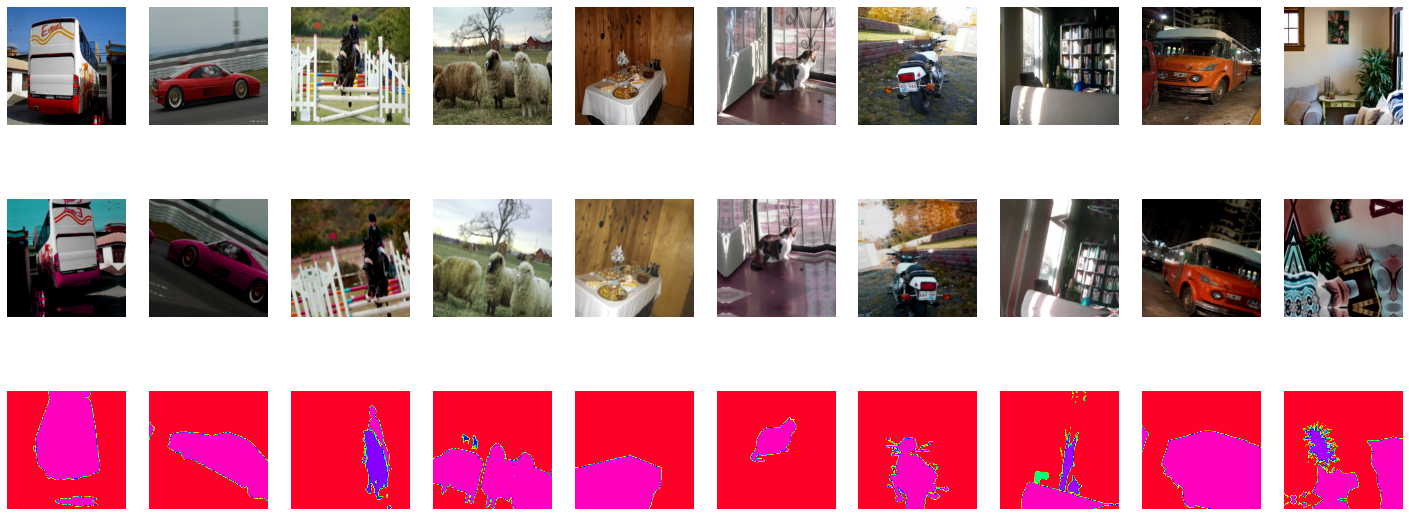

In [11]:
plt.set_cmap('gist_rainbow')
fig = plt.figure(figsize=(25,10))
N = 10
S = 449
ax = fig.subplots(3,N)
for i in range(N):
    ax[0,i].imshow(Ximg_train1[i])
    ax[1,i].imshow(Ximg_aug1[i+S])
    ax[2,i].imshow(ySeg_aug1[i+S])
    ax[0,i].axis('off')
    ax[1,i].axis('off')
    ax[2,i].axis('off')

It is also interesting to look at a single example from the training set, to see the effects of the augmentations

* 1st row: Augmented images
* 2nd row: Augmented segmentation masks
* 1st column: Original unaugmented images/masks

It can be clearly seen that the car is:
* Now pointing left and right (flips).
* Moved around the frame (translations).
* Points in different directions (rotations).
* Appears at different scales (zooms).
* Appears bright and darker (brighten).
* Has slightly different colours (hue).

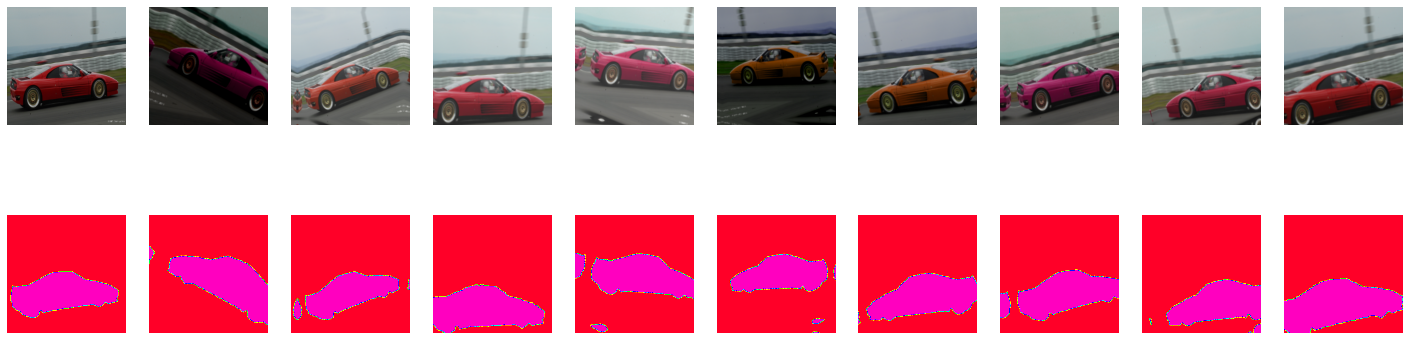

In [12]:
fig = plt.figure(figsize=(25,7))
N = 10
S = 449
offset = 1
ax = fig.subplots(2,N)
for i in range(N):
    ax[0,i].imshow(Ximg_aug1[offset + S*i])
    ax[1,i].imshow(ySeg_aug1[offset + S*i])
    ax[0,i].axis('off')
    ax[1,i].axis('off')

# Semantic Segmentation

We load some specific libraries containing segmentation models.

In [13]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

from segmentation_models import Unet #library with DNNs for Image Segmentation based on Keras framework.

Segmentation Models: using `keras` framework.


## Intro

Second part of the assignment consisted of implementing and training a model for semantic segmentation. For a provided training image, a semantic segmentation model must provide a segmentation map that is as close to as possible to the ground truth segmentation mask. By segmentation mask we mean a collection of labels for each pixel in the image. It is important to stress here the difference between the segmentation and the classification setup where labeling occurs at pixel-level and image-level respectively. Even though a single image can be classified to contain multiple objects, each pixel can only have one adhering label.

Our work here consisted of two parts. First, we implemented and trained a segmentation model from scratch. Second, we utilized a pre-trained model and fine-tuned it for our application. These efforts are presented in the following two sections, proceeded by introducing some general background of our work.

## U-Net 

There are various different model architectures one can choose between for semantic segmentation, as for example U-Net, FPN, Linknet, and PSPNet [3]. We decided to implement U-Net, a well-known convolutional neural network (CNN) segmentation model [1]. This was initially introduced for biomedical imaging to identify tumors from tissue microscopies but can sufficiently be adjusted for the needs of our application. The U-Net follows an encoder-decoder design. An encoder is a CNN for feature extraction which is a form of image downsampling. A decoder, on the other hand, is a CNN for image reconstruction which is a process of image upsampling. In U-Net information processing pipeline, image is first downsampled to to extract mappings of its lower-resolution features. These can efficiently be used to discriminate between the chosen classes. Subsequently, the image is upsampled using this information to provide a segmentation map back at original resolution. Moreover, the U-Net architecture includes the so-called skip connections between the layers of the encoder and decoder. These connections help to reduce the information loss between the original image and the output segmentation map occurring due to the encoder's downsampling operations, providing a more fine-grained segmentation [1].

In the downsampling part, it follows the formula of convolutional layer ->dropout layer -> convolutional layer-> max pooling.  The dropout layer is used as a form of regularization to avoid overfitting by preventing a layer from seeing the same pattern twice,  similar to data augmentation. Max pool layer is used in order to downsample our features by keeping the maximum value in a 2 by 2 stride. 

In the upsampling section, it follows the formula of transpose convolution -> concatenation -> convolutional layer -> dropout -> convolutional layer.  The transpose convolution is an upsampling technique and the concatenation or skip connections, as explained before, is to reduce the information loss between the original image and the output segmentation. 

## Loss functions

Important part of training a neural network model is evaluating how well it models the unseen data. This can be performed by different loss functions computed on the validation data to evaluate the distance between the current and the expected output of the algorithm [5]. In our work, we favour 3 different loss functions:

* Dice loss (DL) - an adaptation of the the Dice coefficient, a metric popular in computer vision community to calculate how similar two images are one to another [6];

$$ DL = \frac {1 − 2yp+ 1} {y + p + 1} $$

* categorical crossentropy (CC) - most widely utilized loss function for multi-class classification problems;

$$ CC = \sum_{i=1}^{output size} y_i \cdot \log p_i $$

* CategoricalFocalLoss (CF) - adaptation of CC that forces the model on puting more attention to learning hard examples [6]. We fond it useful to include because we hypothesized that it might help us improve the performance on highly imbalanced classes.

## IOU Score

While trying to use accuracy in segmentation tasks can be easy to use as the concept of percentage of pixels that are classified correctly, it is not the best metric. The problem arises when there is a high class imbalance and, unfortunately, in real world data that is the case. In order to overcome this the intersection over union score (IoU) will be used. IoU is the intersection or overlap of the predicted segmentation and the ground truth, divided by the union of these two. A score of 1 signifies a perfect overlap of predicted and ground truth segmentation while a score of 0 is no overlap. In our case, it will be the average of each of the classes. The the validation IoU score was set as an early stopping method of model training as the model will overfit and start to perform worse when the validation IoU score increases.  

$$ IoU(𝐴,𝐵)= \frac {𝐴∩𝐵} {𝐴∪𝐵} $$
                 

## Finding the best hyperparameters

Below we include an exemplary code for our network hyperparameters optimization process utilizing the keras_tuner package. There are many different optimization strategies supported by the package, but we decided to go for bayesian optimization since it builds a probability model of the objective function and uses it to select the most promising hyperparameters throughout the search.


In [14]:
"""
from keras_tuner import HyperParameters as hp
import keras_tuner as kt

dl2 = DataLoader(Ximg_aug,
                keras.utils.to_categorical(ySeg_aug, num_classes= 21),
                batch_size = 150,
                shuffle=True)

def build_model(hp):

    # choose the optimizer
    optimizer_choice = hp.Choice("my_optimizer", ["adam", "sgd"]
    if optimizer_choice == "adam":
        lr = hp.Float('learning_rate_adam', 1e-4, 1e-1, sampling='log')
        my_optimizer = keras.optimizers.Adam(learning_rate=lr)
    if optimizer_choice == "sgd":
        lr = hp.Float('learning_rate_sgd', 1e-4, 1e-1, sampling='log')
        mo = hp.Float('momentum', 0, 1, sampling='linear')
        my_optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=mo)

    # choose the loss function
    loss_choice = hp.Choice("my_loss",["DiceLoss", "CategoricalCELoss", "CategoricalFocalLoss"])
    if loss_choice == "DiceLoss":
        my_loss = sm.losses.DiceLoss(beta=1, class_weights=None, class_indexes=None, per_image=False, smooth=1e-05)
    if loss_choice == "CategoricalCELoss":
        my_loss = sm.losses.CategoricalCELoss(class_weights=None, class_indexes=None)
    if loss_choice == "CategoricalFocalLoss":
        my_loss = sm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0, class_indexes=None)

    # choose backbone
    my_backbone = hp.Choice("my_backbone", ['vgg16', 'vgg19', 'resnet34', 'resnet50'])

    #define model  
    iou = sm.metrics.IOUScore()
    model = Unet(my_backbone, classes=21, activation='softmax', input_shape=(128, 128, 3), encoder_weights='imagenet', encoder_freeze=True)
    model.compile(optimizer=my_optimizer, 
                  loss=my_loss, 
                 metrics=['accuracy', iou])

    return model

tuner = kt.tuners.BayesianOptimization(build_model, kt.Objective("val_iou_score", direction="max"), max_trials=25)

my_callbacks = tf.keras.callbacks.EarlyStopping(
                    monitor='val_iou_score', #val_iou_score, val_loss
                    min_delta=0.01,
                    patience=10,
                    mode="max", #max for iou; min for loss
                    restore_best_weights=True)

tuner.search(dl2,
             epochs=100,
             validation_data=(Ximg_val,keras.utils.to_categorical(ySeg_val, num_classes= 21)),
             callbacks = [my_callbacks]
              )
"""

'\nfrom keras_tuner import HyperParameters as hp\nimport keras_tuner as kt\n\ndl2 = DataLoader(Ximg_aug,\n                keras.utils.to_categorical(ySeg_aug, num_classes= 21),\n                batch_size = 150,\n                shuffle=True)\n\ndef build_model(hp):\n\n    # choose the optimizer\n    optimizer_choice = hp.Choice("my_optimizer", ["adam", "sgd"]\n    if optimizer_choice == "adam":\n        lr = hp.Float(\'learning_rate_adam\', 1e-4, 1e-1, sampling=\'log\')\n        my_optimizer = keras.optimizers.Adam(learning_rate=lr)\n    if optimizer_choice == "sgd":\n        lr = hp.Float(\'learning_rate_sgd\', 1e-4, 1e-1, sampling=\'log\')\n        mo = hp.Float(\'momentum\', 0, 1, sampling=\'linear\')\n        my_optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=mo)\n\n    # choose the loss function\n    loss_choice = hp.Choice("my_loss",["DiceLoss", "CategoricalCELoss", "CategoricalFocalLoss"])\n    if loss_choice == "DiceLoss":\n        my_loss = sm.losses.DiceLoss(b

# Data

We utilize a subset of PASCAL VOC 2009 dataset provided for the assignment consisting of color images of 20 different objects, as for example, a dog, a cat, a bicycle, a bus etc. There are 21 possible labels (20 object classes and an extra non-object class for the pixels representing the background).

It is important to note that data normalization is a crucial step of every deep learning application as it decreases the neural network training time and prevents the phenomena of so-called exploding weights. This occurs due to the large variance of data values causing uneven updates to model weights during training. In computer vision, normalization of image pixels is required by either dividing them by 255 or by centering them to mean 0 and unit variance. 

We performed normalization within the neural network models right after the input layer. For the from-scratch-model, this was performed by a Keras Lambda layer that allows definition of an arbitrary expression to be performed on the layer's inputs (in our case, this was division by 255). For the transfer-learning-model, normalization was performed by including a batch-normalization layer right after the input layer. The batch-norm layer calculates the mean and variance of each data batch, and used this information to transform its inputs to mean zero and the output standard deviation of one [2].


In [15]:
## load data

IMG_SIZE = 256
data_folder = "data-augmentation-v3" # data-augmentation, data-augmentation-v2

Ximg_aug = np.load(f"/kaggle/input/{data_folder}/{IMG_SIZE}/aug1/Ximg.npy",mmap_mode='r')
ySeg_aug = np.load(f"/kaggle/input/{data_folder}/{IMG_SIZE}/aug1/ySeg.npy",mmap_mode='r')
yCat_aug = np.load(f"/kaggle/input/{data_folder}/{IMG_SIZE}/aug1/yCat.npy",mmap_mode='r') 

Ximg_aug_traintest = np.load(f"/kaggle/input/{data_folder}/{IMG_SIZE}/aug2/Ximg.npy",mmap_mode='r')
ySeg_aug_traintest = np.load(f"/kaggle/input/{data_folder}/{IMG_SIZE}/aug2/ySeg.npy",mmap_mode='r')
yCat_aug_traintest = np.load(f"/kaggle/input/{data_folder}/{IMG_SIZE}/aug2/yCat.npy",mmap_mode='r') 

Ximg_val = np.load(f"/kaggle/input/{data_folder}/{IMG_SIZE}/val/Ximg.npy")
ySeg_val = np.load(f"/kaggle/input/{data_folder}/{IMG_SIZE}/val/ySeg.npy")
yCat_val = np.load(f"/kaggle/input/{data_folder}/{IMG_SIZE}/val/yCat.npy")   

Ximg_test= np.load(f"/kaggle/input/{data_folder}/{IMG_SIZE}/test/Ximg.npy")
ySeg_test = np.load(f"/kaggle/input/{data_folder}/{IMG_SIZE}/test/ySeg.npy")
yCat_test = np.load(f"/kaggle/input/{data_folder}/{IMG_SIZE}/test/yCat.npy") 


## define data loader
class DataLoaderMemFix(tf.keras.utils.Sequence):
    def __init__(self,X,y,batch_size=32,shuffle=True,toCat = None):

        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.toCat = toCat
        
        self.Nimages = self.X.shape[0]
        self.idx = np.arange(self.Nimages)
        
    def on_epoch_end(self):
        # At the end of each epoch, reshuffle the data frame.
        if self.shuffle:
            np.random.shuffle(self.idx)

    def __len__(self):
        # Get the number of batches corresponding to the dataset.
        return int( np.floor( self.Nimages / self.batch_size ) )
    
    def __getitem__(self,index):
        batch_start = index*self.batch_size
        batch_end   = (index+1)*self.batch_size

        X = self.X[self.idx[batch_start:batch_end]]
        y = self.y[self.idx[batch_start:batch_end]]
        if self.toCat:
            y = keras.utils.to_categorical(y, num_classes= self.toCat)
        return X,y

As already described above, our dataset is hugely unbalanced as some classes are over-representd. Moreover, our inspections unveiled that pixels belonging to background are the most prevalent on images and account to approximately 77.6% of all pixels. This is a significant unbalance, and we aimed to tackle this by providing class weights to our loss function during training in order to adapt it to the presence of a particular class. In this, we summed the counts of pixel-labels per class for all images. Next, we transformed the counts following the equation $1/c * total/2$, where $c$ is the count for the class and total the sum fo counts for all classes. This follows semantic segmentation class balancing procedure provided by [4]. However, doing so we did not manage to improve the network performance and even made its training worse. We again tried by putting all training weights to 1 except the weight of the background class to 0.1 due to its over presence in the pictures. As we could not improve the model training even by doing so, we decided to omit our balancing efforts.

In [16]:
## calculate class weights

if False:
    all_pixels = ySeg_aug.flatten()
    unique, counts = np.unique(all_pixels, return_counts=True)
    # print(counts)
    for u, c in zip(unique, counts):
        print(f"{u} -- {c}")
    total = len(all_pixels)
    class_weights = np.array([1/c * total/2 for c in counts])
    print(class_weights)

# Segmentation model - From scratch

The U-Net architecture is implemented [7] and He Normal was used to initialize the weights [8]. The He Normal initialization takes samples from a normal distribution centered on zero and is suitable with ReLu activation functions which can capture non-linearities and avoids the vanishing gradient on one side. Weight initialization is important as the weights of the network are initialized and then repeatedly updated when training the model until a minimum loss is reached. Given that weight initialization is an important factor of network convergence, He Normal was used as it has been proved to give good performance. 

A hyperparameter search was performed on the optimizer, learning rate and loss function using random search given as it has been proved to perform better in high dimensional spaces. The batch size was set to 32, as seen from the lecture on intro to deep learning [9], the batch size is the number of train samples that the network uses for each weight update step. A smaller batch size while computationally more expensive, has a better generalization. Even though the best parameters found from the hyperparameter search were used, the model still did not perform well due to the low amount of data and the almost 2 million parameters to train.

In [17]:
## hyperparameters

# parameters found in optimization search
adam_opt = keras.optimizers.Adam(learning_rate=0.00125)
sgd = tf.keras.optimizers.SGD(learning_rate=0.072411, momentum= 0.88548 )
categorical_focal = sm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0, class_indexes=None)
loss_Dice = sm.losses.DiceLoss(beta=1, class_weights=None, class_indexes=None, per_image=False, smooth=1e-05)

# metrics
iou = sm.metrics.IOUScore()
mean_iou=tf.keras.metrics.MeanIoU(num_classes= 21, name="mean_iou", dtype=None)

2022-05-24 20:50:16.247307: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [18]:
## initialize model

if False: #skip
    
    IMG_CHANNELS = 3
    classes= 21

    #Input
    inputs = tf.keras.layers.Input((IMG_SIZE,IMG_SIZE, IMG_CHANNELS))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3) #0.2
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)#0.2
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5) #0.3
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    #Output
    outputs = tf.keras.layers.Conv2D(classes, (1, 1), activation='softmax')(c9)

    model1 = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    model1.compile(optimizer=adam_opt, loss= 'categorical_crossentropy' , metrics=[iou, mean_iou]) #'categorical_crossentropy'  tf.keras.metrics.OneHotMeanIoU(num_classes=21)

In [19]:
if False: #skip
    
    dl1 = DataLoaderMemFix(Ximg_aug[0:5*449],
                    ySeg_aug[0:5*449],
                    batch_size = 32,
                    shuffle=True,
                    toCat = 21)

    history1 = model1.fit(
              dl1,
              epochs=30,
              validation_data=(Ximg_val,keras.utils.to_categorical(ySeg_val, num_classes= 21)),
             )
    
    history1 = history1.history

In [20]:
## load our model
model1 = tf.keras.models.load_model('../input/segmentation-models/results_jacob2/unet_scratch_256',compile=False)

## load our training history
with open('../input/segmentation-models/history_unet_scratch_256.pkl', 'rb') as f:
    history1 = pickle.load(f)

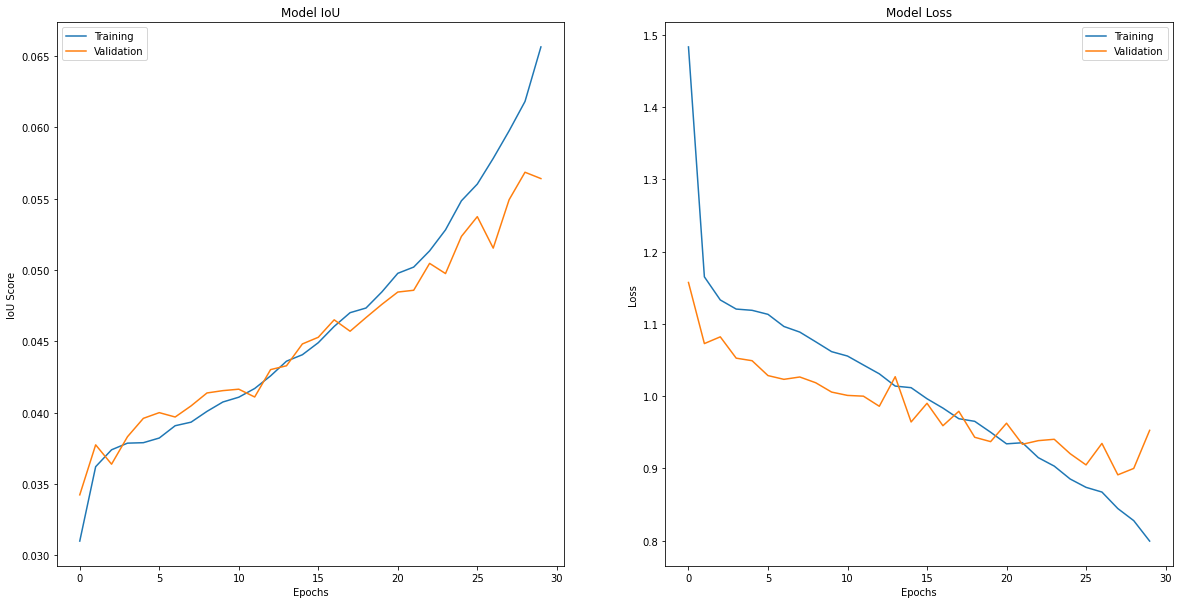

In [21]:
## plots

fig = plt.figure(figsize=(20,10))
ax = fig.subplots(1,2)

# summarize history for accuracy
ax[0].plot(history1['iou_score'])
ax[0].plot(history1['val_iou_score'])
ax[0].set_title('Model IoU')
ax[0].set_ylabel('IoU Score')
ax[0].set_xlabel('Epochs')
ax[0].legend(['Training', 'Validation'])

# summarize history for loss
ax[1].plot(history1['loss'])
ax[1].plot(history1['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['Training', 'Validation'])

2022-05-24 20:50:45.339935: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


<Figure size 432x288 with 0 Axes>

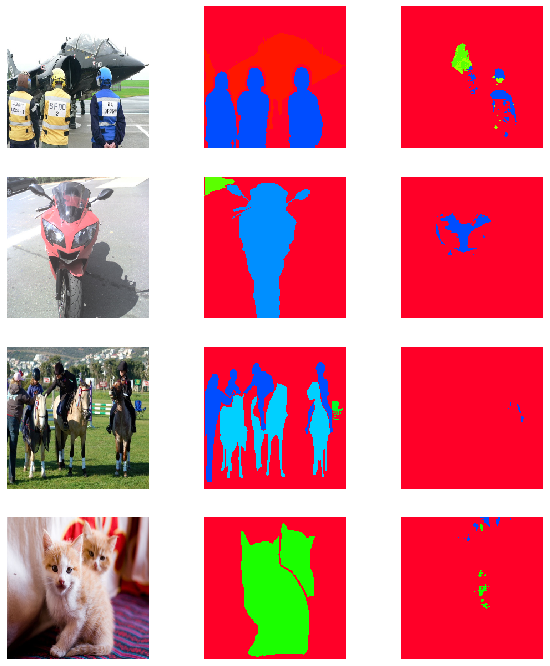

In [22]:
## plots

Ypred = model1.predict(Ximg_test)
Ypred = np.argmax(Ypred,axis=3)
Ypred.shape

Nplot = 4

plt.set_cmap('gist_rainbow')
fig = plt.figure(figsize=(10,3*Nplot))
ax = fig.subplots(Nplot,3)
#ax = ax.flatten()

for i in range(Nplot):
    ax[i,0].matshow(Ximg_test[i])
    ax[i,1].matshow(ySeg_test[i],vmin=0,vmax=21)
    ax[i,2].matshow(Ypred[i],vmin=0,vmax=21)
    ax[i,0].axis('off')
    ax[i,1].axis('off')
    ax[i,2].axis('off')

Inspecting the IoU score and loss plots, and also its segmentation performance in comparisson to the ground truth plots, we observe that the from-scratch-model was not performing well. Therefore, we decided to put significant efforts in using transfer-learning approaches.

In [23]:
## save
if False: #skip
    #save model
    outname = 'unet_scratch_256'
    model1.save(outname)
    
    #save history
    with open('unet_scratch_256_trainHistoryDict1.pkl', 'wb') as fh:
        pickle.dump(history1.history, fh)

In [24]:
del model1 #save space

# Segmentation model - Transfer learning

Next, we utilized a U-Net model pretrained on the Imagenet data set as implemented in the segmentation_models package [3]. This allows us to also decide a CNN architecture backbone on which the model is built on. We performed a hyperparameter tuner (BayesianOptimization) to find the most suitable backbone, optimal loss function and learning rate of the ADAM optimizer. We are aware of the fact that SGD optimizer provides better results than ADAMis better, but ADAM is more convenient to use, so we use it here. Next to the ADAM optimizer learning rate and three candidate loss functions (DL, CC, CF), the following set of model backobnes was included in the search:
* vgg16, 
* vgg19, 
* resnet34, 
* resnet50.

The Bayesian tuner algorithm was ran for 20 iterations, identifying the optimal set of parameters to be learning rate of 0.001, CC loss, and the resnet 34 backbone.

In [25]:
## hyperparameters

# parameters found in optimization search
my_optimizer = keras.optimizers.Adam(learning_rate=0.001)
my_backbone = 'resnet34'
my_loss = sm.losses.CategoricalCELoss(class_weights=None, class_indexes=None) 

# training regime
n_training_epochs1 = 100 #with untrainable encoder
n_training_epochs2 = 100 #with trainable encoder

# callbacks
callback_earlystop = tf.keras.callbacks.EarlyStopping(
                    monitor='val_iou_score', #val_iou_score, val_loss
                    min_delta=0.002,
                    patience=5,#6
                    mode="max", #max for iou; min for loss
                    restore_best_weights=True)

callback_reducelr = tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_iou_score', 
                    factor=0.75, #0.9
                    patience=3 #2
                    )

# metrics
iou = sm.metrics.IOUScore()

In [26]:
## initialize model

if False: #skip
    model2 = Unet(my_backbone, classes=21, activation='softmax', input_shape=(256, 256, 3), encoder_weights='imagenet', encoder_freeze=True)

    model2.compile(optimizer = my_optimizer, 
                  loss=my_loss,
                  metrics=['accuracy', iou]) #iou_score, FScore, accuracy, One

    dl2 = DataLoaderMemFix(Ximg_aug,
                    ySeg_aug,
                    batch_size = 50,
                    shuffle=True,
                    toCat = 21)

We first trained the model with encoder weights frozen (100 training epochs in batches of 50), and then decreased the learning rate for fine-tuning the whole model for additional 100 epochs. Both training regimes were limited by early stopping with patience of 5 epochs focusing on the IoU score. If the validation set IoU score is not improved by 0.002 in 5 epochs, the training stops. Additionally, the second training also had implemented a reducing learning rate implemented by monitoring the val_iou_score. If this has not improved for 4 epochs, the learning rate has been multiplied by 0.75. This was done in order to prevent too-big deviations which could change the previously frozen encoder too much. 

In [27]:
## train with frozen encoder
if False: #skip
    history21 = model2.fit(
              dl2,
              epochs=n_training_epochs1,
              validation_data=(Ximg_val,keras.utils.to_categorical(ySeg_val, num_classes= 21)),
              callbacks = [callback_earlystop]
                          )

In [28]:
## train with unfrozen encoder

if False: #skip

    # make all layers available for training
    for layer in model2.layers:
        layer.trainable = True

    #now fine-tune whole model with lower lr!
    from keras import backend as K
    K.set_value(model2.optimizer.learning_rate, 0.0001)

    history22 = model2.fit(
              dl2,
              epochs=n_training_epochs2,
              validation_data=(Ximg_val,keras.utils.to_categorical(ySeg_val, num_classes= 21)),
              callbacks = [callback_earlystop,callback_reducelr]
                          )

In [29]:
## join histories

if False: #skip
    history2 = {}
    for key in history21.history:
        history2[key] = history21.history[key] + history22.history[key]

In [30]:
## load our model

model2 = tf.keras.models.load_model('../input/segmentation-models/results_jacob2/unet_transfer_256',compile=False)

## load our training history
with open('../input/segmentation-models/history_unet_transfer_256.pkl', 'rb') as f:
    history2 = pickle.load(f)

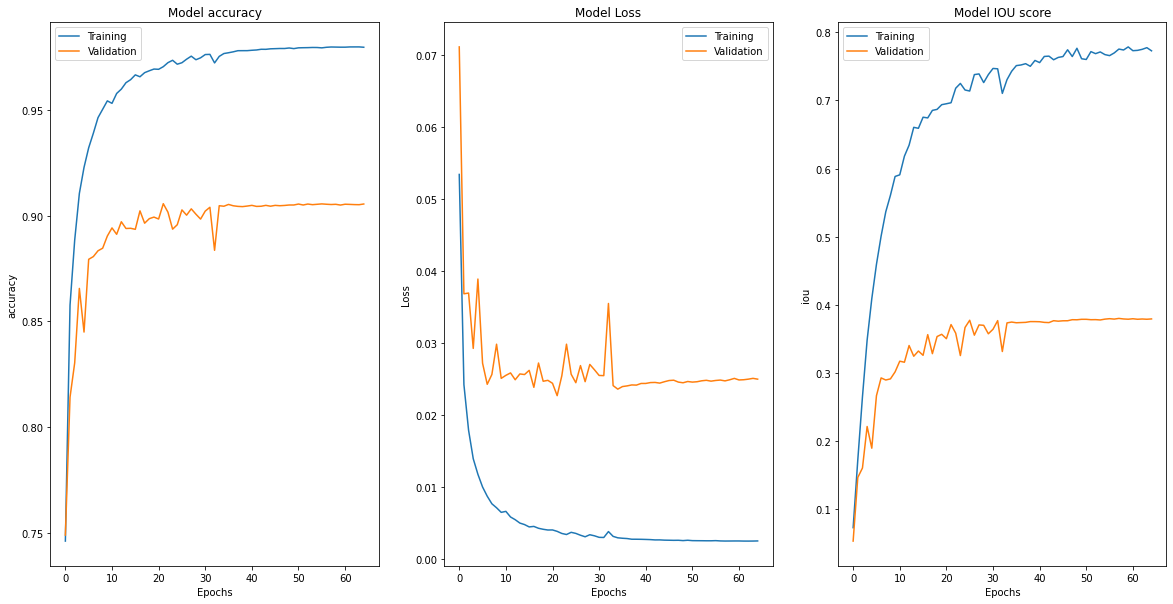

In [31]:
## plot

fig = plt.figure(figsize=(20,10))
ax = fig.subplots(1,3)

# summarize history for accuracy
ax[0].plot(history2['accuracy'])
ax[0].plot(history2['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['Training', 'Validation'])
#ax[0].show()

# summarize history for loss
ax[1].plot(history2['loss'])
ax[1].plot(history2['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['Training', 'Validation'])

# summarize history for iou_score
ax[2].plot(history2['iou_score'])
ax[2].plot(history2['val_iou_score'])
ax[2].set_title('Model IOU score')
ax[2].set_ylabel('iou')
ax[2].set_xlabel('Epochs')
ax[2].legend(['Training', 'Validation'])

<Figure size 432x288 with 0 Axes>

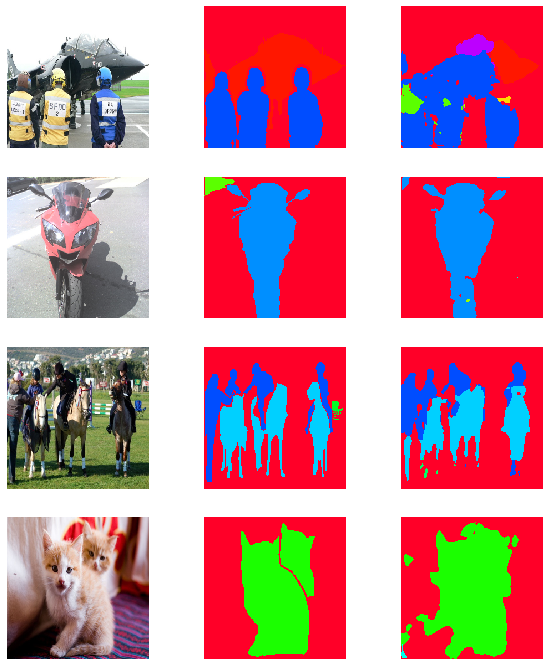

In [32]:
## plot

Ypred = model2.predict(Ximg_test)
Ypred = np.argmax(Ypred,axis=3)
Ypred.shape

Nplot = 4

plt.set_cmap('gist_rainbow')
fig = plt.figure(figsize=(10,3*Nplot))
ax = fig.subplots(Nplot,3)
#ax = ax.flatten()

for i in range(Nplot):
    ax[i,0].matshow(Ximg_test[i])
    ax[i,1].matshow(ySeg_test[i],vmin=0,vmax=21)
    ax[i,2].matshow(Ypred[i],vmin=0,vmax=21)
    ax[i,0].axis('off')
    ax[i,1].axis('off')
    ax[i,2].axis('off')

Inspecting the accuracy and loss plots, and also the model's segmentation performance in comparisson to the ground truth plots, we observe that the transfer-learning-model was exhibiting much better performance than the from-scratch-model. Therefore, we decided to include this model in our final submission.

In [33]:
## save

if False: #skip
    outname = 'unet_transfer_256'
    model2.save(outname)
    with open('unet_transfer_256_trainHistoryDict.pkl', 'wb') as fh:
        pickle.dump(history2, fh)

In [34]:
del model2 #save space

## Final Segmentation model for submission

In [35]:
## initialize model

if False: #skip
    model3 = Unet(my_backbone, classes=21, activation='softmax', input_shape=(256, 256, 3), encoder_weights='imagenet', encoder_freeze=True)

    model3.compile(optimizer = my_optimizer, 
                  loss=my_loss,
                  metrics=['accuracy', iou])

    dl3 = DataLoaderMemFix(Ximg_aug_traintest,
                    ySeg_aug_traintest,
                    batch_size = 50,
                    shuffle=True,
                    toCat = 21)

In [36]:
## train with frozen encoder

if False: #skip
    history31 = model3.fit(
              dl3,
              epochs=n_training_epochs1,
              validation_data=(Ximg_val,keras.utils.to_categorical(ySeg_val, num_classes= 21)),
              callbacks = [callback_earlystop]
                          )

In [37]:
## train with unfrozen encoder

if False: #skip
    #set all labels to trainable
    for layer in model3.layers:
        layer.trainable = True

    #now fine-tune whole model with lower lr!
    from keras import backend as K
    K.set_value(model3.optimizer.learning_rate, 0.0001)

    history32 = model3.fit(
              dl3,
              epochs=n_training_epochs2,
              validation_data=(Ximg_val,keras.utils.to_categorical(ySeg_val, num_classes= 21)),
              callbacks = [callback_earlystop,callback_reducelr]
                          )

In [38]:
## join histories

if False: #skip
    history3 = {}
    for key in history31.history:
        history3[key] = history31.history[key] + history32.history[key]

In [39]:
## load our model

model3 = tf.keras.models.load_model('../input/segmentation-models/results_jacob2/unet_transfer_256_submission',compile=False)

## load our training history

with open('../input/segmentation-models/history_unet_transfer_256_submission.pkl', 'rb') as f:
    history3 = pickle.load(f)

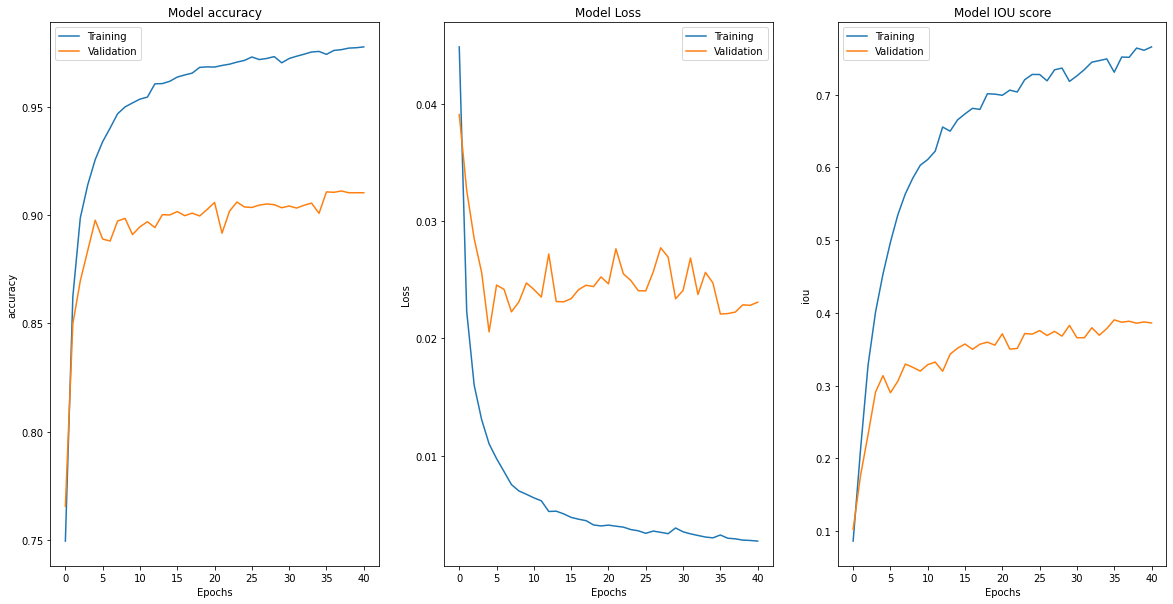

In [40]:
## plot

fig = plt.figure(figsize=(20,10))
ax = fig.subplots(1,3)

# summarize history for accuracy
ax[0].plot(history3['accuracy'])
ax[0].plot(history3['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['Training', 'Validation'])
#ax[0].show()

# summarize history for loss
ax[1].plot(history3['loss'])
ax[1].plot(history3['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['Training', 'Validation'])

# summarize history for iou_score
ax[2].plot(history3['iou_score'])
ax[2].plot(history3['val_iou_score'])
ax[2].set_title('Model IOU score')
ax[2].set_ylabel('iou')
ax[2].set_xlabel('Epochs')
ax[2].legend(['Training', 'Validation'])

In [41]:
## save
if False: #skip
    outname = 'unet_transfer_256_submission'
    model3.save(outname)
    with open('unet_transfer_256_submission_trainHistoryDict1.pkl', 'wb') as fh:
        pickle.dump(history3, fh)

In [42]:
del model3 #save space

# Sources

* 1: https://arxiv.org/abs/1505.04597
* 2: https://arxiv.org/pdf/1805.11604.pdf
* 3: https://segmentation-models.readthedocs.io/en/latest/index.html
* 4: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
* 5: https://towardsdatascience.com/what-is-loss-function-1e2605aeb904
* 6: https://arxiv.org/pdf/2006.14822.pdf
* 7:https://github.com/bnsreenu/python_for_microscopists/blob/master/228_semantic_segmentation_of_aerial_imagery_using_unet/simple_multi_unet_model.py
* 8: He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving deep into rectifiers: Surpassing human-level performance on imagenet classification. In Proceedings of the IEEE international conference on computer vision (pp. 1026-1034).
* 9: Slide56 from intro to dl for classification.

# Classification Model

## Convolutional neural networks

The idea behind convolutional neural networks (CNN) is that they have two parts. The convolutional layers extract features in a hierarchical fashion. The first few layers generally extract simple gabor-like features (cfr. the lectures) which are then arranged by the subsequent layers into increasingly complex patterns. The image below is an example:

![](https://tse2.mm.bing.net/th?id=OIP.tE3ZXnz_t32QHmwHUvfQTQHaCE&pid=Api&P=0&w=528&h=147)

With the intuition being that the convolutional layers help the network to "see" and the dense layers on top help the network "discern" or classify the complex patterns learned from the data, fine-tuning can be regarded as taking a network that can already see and simply teach it how to classify. The convolutional layers thus form a fixed feature extractor that can be reused for various tasks. 

When training a network from scratch we can also leverage existing architectures such as Resnet, one of the most cited papers in the domain of machine learning, or recent innovations like Xception. The advantage of doing this is that the features extracted in the conv layers are directly suited towards the task at hand, however this requires more data than fine-tuning. For this assignment we tried both methods but we found the latter approach to be lacking as we did not have enough data to make it work. These models are typically trained on the imagenet dataset which contains over a million images.

The third approach, which we did not do, is to hand-craft a CNN architecture that is smaller and train that from scratch. We opted to focus on fine-tuning, however in the adversarial attack we do create an architecture from scratch and we demonstrate the choices that are made when doing so. This is an area we could have expanded on if we had more time. 


In [43]:
Ximg_aug1 = np.load(f"/kaggle/input/data-augmentation-v3/{IMG_SIZE}/aug1/Ximg.npy",mmap_mode='r')
ySeg_aug1 = np.load(f"/kaggle/input/data-augmentation-v3/{IMG_SIZE}/aug1/ySeg.npy",mmap_mode='r')
yCat_aug1 = np.load(f"/kaggle/input/data-augmentation-v3/{IMG_SIZE}/aug1/yCat.npy",mmap_mode='r') 

Ximg_aug2 = np.load(f"/kaggle/input/data-augmentation-v3/{IMG_SIZE}/aug2/Ximg.npy",mmap_mode='r')
ySeg_aug2 = np.load(f"/kaggle/input/data-augmentation-v3/{IMG_SIZE}/aug2/ySeg.npy",mmap_mode='r')
yCat_aug2 = np.load(f"/kaggle/input/data-augmentation-v3/{IMG_SIZE}/aug2/yCat.npy",mmap_mode='r') 

Ximg_val = np.load(f"/kaggle/input/data-augmentation-v3/{IMG_SIZE}/val/Ximg.npy")
ySeg_val = np.load(f"/kaggle/input/data-augmentation-v3/{IMG_SIZE}/val/ySeg.npy")
yCat_val = np.load(f"/kaggle/input/data-augmentation-v3/{IMG_SIZE}/val/yCat.npy")

Ximg_train = np.load(f"/kaggle/input/data-augmentation-v3/{IMG_SIZE}/train/Ximg.npy")
ySeg_train = np.load(f"/kaggle/input/data-augmentation-v3/{IMG_SIZE}/train/ySeg.npy")
yCat_train = np.load(f"/kaggle/input/data-augmentation-v3/{IMG_SIZE}/train/yCat.npy")   

In [44]:
class DataLoader(tf.keras.utils.Sequence):
    def __init__(self,X,y,batch_size=32,shuffle=True):

        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.Nimages = X.shape[0]
        
    def on_epoch_end(self):
        # At the end of each epoch, reshuffle the data frame.
        if self.shuffle:
            idx = np.arange(self.Nimages)
            np.random.shuffle(idx)
            self.X = self.X[idx]
            self.y = self.y[idx]
            
    def __len__(self):
        # Get the number of batches corresponding to the dataset.
        return int( np.floor( self.Nimages / self.batch_size ) )
    
    def __getitem__(self,index):
        batch_start = index*self.batch_size
        batch_end   = (index+1)*self.batch_size

        return self.X[batch_start:batch_end],self.y[batch_start:batch_end]

## Find the best classification model

The reuse of a previously learned model on a new problem is known as transfer learning. It’s currently very popular in DL since it can train deep neural networks with little data. The main idea is to use what we’ve learned in one task to better understand the concepts in another. In other words, transfer learning helps us to make our life easier by allowing us to use pre-available Architectures. 
There are more than two dozen pre-trained models available from Keras: Xcemption, AlexNet, VGG16, VGG19, ResNet50, ResNet101 and Google Inception V3 are some of them. Fine tuning those pre-trained weights could help us achieve a good solution for our image dataset.

Different models were trained and tested for this classification task. Furthermore, hyper parameters were fine tuned in order to achieve a consistent accuracy in the validation set. Once our experiments were finished, we compared the results and chose the best model with its corresponding best parameters. Our final model was Xcemption ( tf.keras.applications.Xception) since it showed to have the best results. Notice also that this model gets to a top-1 validation accuracy of 79% and a top-5 validation accuracy of 94.5% in ImageNet dataset. It's also know that Xception has overperformed VGG-16, ResNet and Inception V3 in most classical classification tasks.

### How Xception looks like

The data first goes through the entry flow, then it goes through the middle flow (repeating itself 8 times in this middle flow), and finally through the exit flow.
It's important to mention that all Convolution and SeparableConvolution layers are followed by batch normalization although it's not added in the diagram. What batch normalization does is that it accelerates the training process. It also makes the network more stable by re-centering and re-scaling.

![](https://miro.medium.com/max/1400/1*t6qfo9ucYza_lbLfg5-p_w.png)

## How does Xception work?

This architecture relies mainly on two main items:
   - 1) Depthwise Separable Convolution:  they used as an alternative to classical convolutions since they are more efficient in terms of computation time. These SeparableConvs are placed heavily through the whole deep learning architecture. This is what really powers the Xception.  
   - 2) Shortcuts between Convolution blocks
    
    
Xcemption (also known as extreme inception) it is based on the principles of Inception model. In Inception, 1x1 convolutions were used to flatten the input, and from each of those input spaces we used different type of filters on each of the depth space. Xception just reverses the order of these two. It first applies the filters on each of the depth map and then finally compresses the input space using 1X1 convolution by applying it across the depth. Furthermore, Xception and Inception differ in one more thing. Whereas in the Inception model, both operations are followed by a ReLU, Xception doen't introduce any non-linearity.

As it is seen in the diagram above, one can find 3 main flows in this architecture:

- ENTRY FLOW: Notice that the very first module does contain conventional convolutional layers. The input tensor has a size of (-1, 299,299,3). The -1 just denotes that the batch size can be whatever. Excluding this first module, all the others in the entry flow have residual skip connections. Three convolutional blocks can be found in this part. Notice that the initial input has dimensions (299x299x3 = 268.203) and the output's size is (19x19x728 = 262.808). What we can conclude is that the goal of this entry flow is not to reduce dimensionality but learn different features about the input images. 

- MIDDLE FLOW: In this middle flow, the module is repeated 8 times one after the other. All of these use a stride of 1 and there are no pooling layers. What this means is that the size of the tensor that’s passed from the entry flow remains the same. Besides, the channel depth remains the same too as all the middle flow modules have 728 filters. It is important to mention that the goal of this middle flow is to "massage" all these features that have been found in the entry flow until it gets some nice features.

- EXIT FLOW: The exit flow just has 2 convolutional modules and the second one does not contain any skip connection. In contrast to the previous modules that were using Maxpooling, Global Average Pooling is used in the second module of this flow. Later, the output vector from the Average Pooling is given to the logistic regression. Note that dimensionality reduction was performed in this part of the flow (from 19x19x728 to a 2048 vector).

## Our final model

As it was explained above, our base model was Xcemption and then some layers were added to it. Before adding these layers, a particular preprocessing step was applied since each Keras Application expects a specific kind of input preprocessing. For Xception, tf.keras.applications.xception.preprocess_input(x) is used to normalize the images accoridingly. By doing this, our images were scaled to the range [-1,1].  

Let's talk now about the extra layers we decided to add: first of all, a Global Average Pooling 2D was added in order to to reduce the dimensionality. A Dense Layer was added afterwards. Later, a Dropout layer was added to prevent from overfitting. This prevents a later from seeing the same pattern several times. 
For the output layer we use a Dense with 20 units since our problem contains 20 different objects. Sigmoid was used as activation function since it's the appropiate one for a multi-label classification task. This function will return probabilities for each class going from 0 to 1.

Loss function: Since we are in a multi-label classification problem the loss function we need to use is Binary cross entropy.

$$  L_{BCE} = -{(y\log(p) + (1 - y)\log(1 - p))} $$


## Hyperparameter Tuning

In order to improve the performance of our model hyperparameter tunning was done. The goal of hyperparameter tunning is to choose a set of optimal hyperparameters for a learning algorithm. There are many different strategies to approach this, such as: human tuning, grid search, random search and basyesian optimization.

We decided to go for bayesian optimization since it builds a probability model of the objective function and uses it to select the most promising hyperparameters. It works well for high-dimensional problems, hence deep learning models, and it has a lower cost if we compare it to other methods.

We tunned the following parameters:
- The number of neurons of the Dense layer. We tried many different number of neurons going from 256 to 1024 in steps of 32 but finally 1024 gave the best result.
- The Dropout: we tried from 0.1 to 0.8 but in the end a value of 0.5 happened to give the best result.
- Learning rate: different values were tried, some of them: 0.01, 0.001, e-4 and 3e-4, but 0.0001 happened to give the best result.


## Fitting

We put a batch of size 32 and  250 epochs. Note that several bach sizes were tried (16, 32, 64, etc) but 32 gave the best results. To avoid overfitting, early stopping was used by passing it to the fit method as a callback function. This helps to reduce the computational load by stopping earlier as the name indicate. The patience parameter can be tuned to specify how soon early stopping should apply but we kept it fixed to 5. 

We tried to build a model from scratch by using several existing architectures. We mainly foucsed in ResNet50 and Xcemption since they are well known architectures but due to the poor amount of data our models didn't perform well. Our highest accuracy in the validation using Resnet50 was 0.2101 and 0.2305 with Xception architecture.

 - WHAT WE DID NOT DO BUT WISHED TO: in an ideal scenario, we would have loved to train our own model from scratch end to end. It was clear that training from scratch with these models was not gonna work since they were trained with a bunch of images. For instance, ResNet50 was trained on more than one million images from the ImageNet database. Probably with a way bigger dataset this would have worked properly!


## Fitting

In [46]:
IMG_SIZE = [256,256]
def build_model(hp):
    base_model = tf.keras.applications.Xception(
        include_top=False,
        weights= 'imagenet',
        classes = 20,
        input_shape= IMG_SIZE+[3])

    
    
    base_model.trainable = False
        
    data_augmentation = keras.models.Sequential([keras.layers.RandomFlip("horizontal"),
                                                 keras.layers.RandomRotation(0.2), 
                                                keras.layers.RandomZoom(height_factor=(-0.4, -0.2))])
    scale_layer = keras.layers.Rescaling(scale=1 / 255)

    inputs = keras.Input(IMG_SIZE+[3])
    x = data_augmentation(inputs)
    x = scale_layer(x)
    x = base_model(x, training=False)
    x = keras.layers.GlobalAvgPool2D()(x)
    x = keras.layers.Dense(hp.Int('hidden_size1', 256, 1024, step=32, default=256),activation='relu')(x)
    x = tf.keras.layers.Dropout(hp.Float('dropou1t', 0, 0.8, step=0.1, default=0.5))(x)
    output = keras.layers.Dense(units = 20, activation = 'sigmoid')(x)



    model = keras.Model(inputs, output)
    model.compile(
          optimizer=keras.optimizers.Adam( hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
          loss=keras.losses.BinaryCrossentropy(),
          metrics= ['accuracy'])
    model.summary()
    return model

#tuner = kt.tuners.BayesianOptimization(build_model, 'val_accuracy', max_trials=50)
#tuner.search(Ximg_train, yCat_train,
#                batch_size= 32,
#                            epochs=250, verbose=1,
#                            validation_data=(Ximg_val,yCat_val),
#                            callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

## Final Model

Once we have tuned we selected the best parameters for our final model

In [47]:
def build_model():
    base_model = tf.keras.applications.Xception(
        include_top=False,
        weights= 'imagenet',
        classes = 20,
        input_shape= IMG_SIZE+[3])
    
    base_model.trainable = False
    inputs = keras.Input(IMG_SIZE+[3])
    x = tf.keras.applications.xception.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = keras.layers.GlobalAvgPool2D()(x)
    x = keras.layers.Dense(1024,activation='relu')(x)   
    x = tf.keras.layers.Dropout(0.8)(x)
    
    output = keras.layers.Dense(units = 20, activation = 'sigmoid')(x)

    model = keras.Model(inputs, output)
    model.compile(
          optimizer=keras.optimizers.Adam(learning_rate = 3e-4),
          loss=keras.losses.BinaryCrossentropy(),
          metrics= ['accuracy'])
    model.summary()
    return model



# With 512 neurons: val_accuracy: 0.7133
# With 1024 neurons:  val_accuracy: 0.7533


In [48]:
best_model = build_model()

83697664/83683744 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 256, 256, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
______________________________________________________________

## Training

In [49]:
#history = best_model.fit(Ximg_aug1, yCat_aug1,
#                          validation_data=(Ximg_val,yCat_val),
#                        batch_size= 64,
#                            epochs=250, verbose=1,
#                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

## Validation checks

In [50]:
## load our training history

with open("../input/classification-models/trainHistoryDict_aug2.pkl", 'rb') as f:
    history = pickle.load(f)

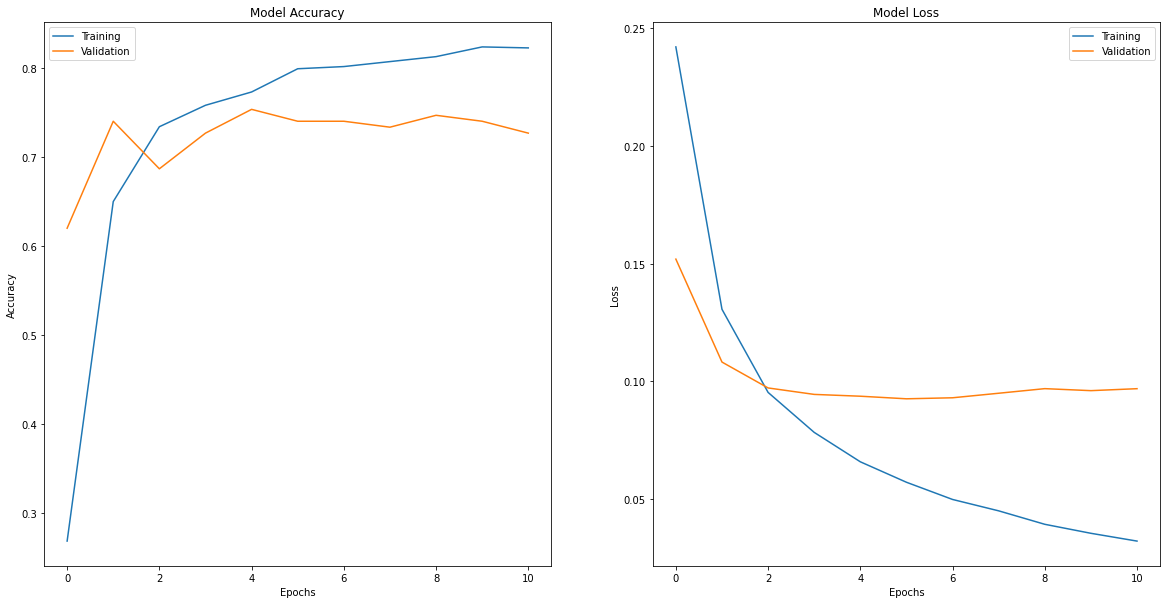

In [51]:
fig = plt.figure(figsize=(20,10))
ax = fig.subplots(1,2)

# summarize history for accuracy
ax[0].plot(history['accuracy'])
ax[0].plot(history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['Training', 'Validation'])
#ax[0].show()

# summarize history for loss
ax[1].plot(history['loss'])
ax[1].plot(history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['Training', 'Validation'])

# Results discussion

We know discuss the performance of the models on the testing data.

We:
* Load the models fitted on the (augmented) training data.
* Load the testing data.
* Make the predictions for both the classifer and the segmentation.

In the following plots the different colours at the segmentation boundary is a result of plotting and not present in the data.

In [52]:
IMG_SIZE = 256
labels = ['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']

In [98]:
class_model = tf.keras.models.load_model("/kaggle/input/classification-models/classification_aug1")
seg_model   = tf.keras.models.load_model("/kaggle/input/segmentation-models/results_jacob2/unet_transfer_256",compile=False)

In [106]:
IMG_SIZE = 256
Ximg_test = np.load(f"/kaggle/input/data-augmentation-v3/{IMG_SIZE}/test/Ximg.npy")
ySeg_test = np.load(f"/kaggle/input/data-augmentation-v3/{IMG_SIZE}/test/ySeg.npy")
yCat_test = np.load(f"/kaggle/input/data-augmentation-v3/{IMG_SIZE}/test/yCat.npy")  

In [107]:
catPred = class_model.predict(Ximg_test)
catPred = np.round(catPred)

segPred = seg_model.predict(Ximg_test)
segPred = np.argmax(segPred,axis=3)

## Segmentation performance

In [55]:
def getPlotDisplay(xImg,ySeg_true,ySeg_pred,cat_true,cat_pred):
    def plotAtOffset(offset):
        N = 5
        fig = plt.figure(figsize=(24,16))
        ax = fig.subplots(3,N)
        for i in range(N):
            ii = i+offset
            ax[0,i].imshow(xImg[ii])
            ax[1,i].imshow(ySeg_true[ii],vmin=0,vmax=21)
            ax[2,i].imshow(ySeg_pred[ii],vmin=0,vmax=21)
            ax[0,i].axis('off')
            ax[1,i].axis('off')
            ax[2,i].axis('off')

            pred_str = "Pred: " + ",".join( list(np.array(labels)[cat_true[ii]==1]))
            true_str = "True: " + ",".join( list(np.array(labels)[cat_pred[ii]==1]))
            ax[0,i].set_title(pred_str + "\n" + true_str)
    return plotAtOffset

In [ ]:
# fig = plt.figure(figsize=(20,20))
# ax = fig.subplots(1,1)
# ax.imshow(segPred[1],vmin=0,vmax=21)

In [62]:
good_indices = [1,2,14,40,42] # TBD
bad_indices  = [5,24,56,63,76]  # TBD 

plotdisplay_all  = getPlotDisplay(Ximg_test,ySeg_test,segPred,yCat_test,catPred)
plotdisplay_good = getPlotDisplay(Ximg_test[good_indices],ySeg_test[good_indices],segPred[good_indices],yCat_test[good_indices],catPred[good_indices])
plotdisplay_bad  = getPlotDisplay(Ximg_test[bad_indices],ySeg_test[bad_indices],segPred[bad_indices],yCat_test[bad_indices],catPred[bad_indices])

First, we discuss our model's good performance where there are different categories.  
* Instances where our model performed well in easy conditions such as the first image in the figure below where the model is able to segment almost perfectly the motorbike. Moreover, our model performed well in more difficult conditions such as the second picture where itl is able to differentiate between what is a leg of a person sitting on a horse and what is horse, even though it is a difficult task. 
* Instances where the model performed better than the ground truth segmentation such as the third image. On the third image the model performs better than the ground truth map as it identifies an additional bus in the background which is occluded.
* Instances where the predicted segmentation is different from the ground truth due to semantic reasons. In the fourth picture apart from recognizing a person and a table, the network recognizes the plastic ketchup bottle that is also on the ground truth segmentation but cans are also seen as bottles and this is semantically quite a reasonable mistake. On the fifth picture the ground truth segmentation shows the objects classified as chairs but the model prediction classifies them as couches. In our opinion the model prediction is right as these are couches for a single person but another person may semantically differ. 


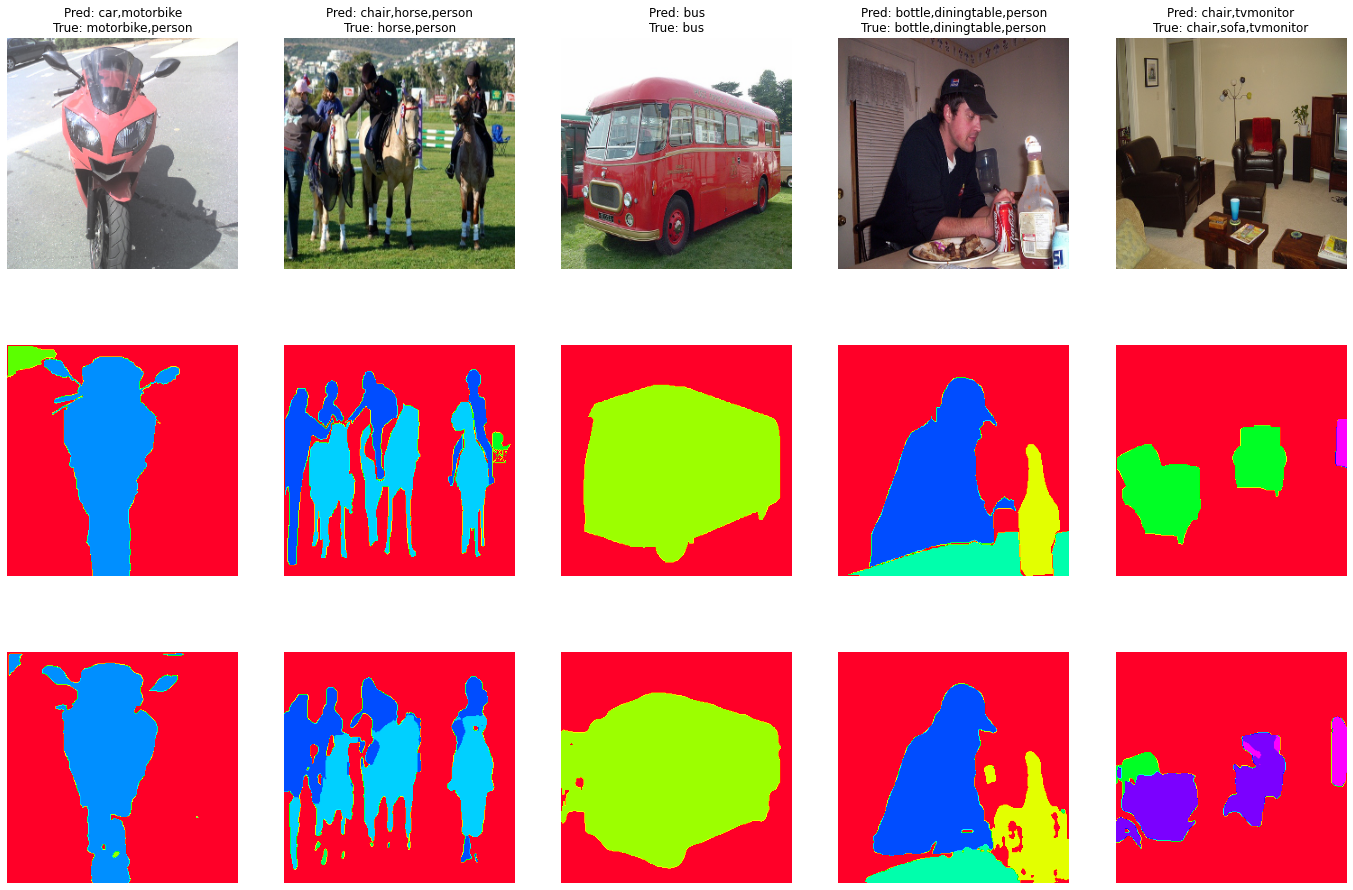

In [63]:
plotdisplay_good(0)

Continuing our discussion on examples that illustrate the overall difficulties of the segmentation's model performance:
* On the first image from the left we see that the cat's face was wrongly segmented as the human face. This is a common problem we notice when examining the classifications, and we believe it is a consequence of an overrepresentation of the human class (almost 30% of all images) in our dataset, which made the network wrongly connect the face features (which generalize quite well among animal species) as adhering to the human class. 
* Next, as the second from the left, we see a cat wrongly segmented as a dog. What is more interesting about this segmentation is the cat's surroundings, which are in the ground truth segmentation map labeled as "cat". This is a mistake and our network did correctly not label the surroundings as "cat" (even though it could instead label them as couch)
* Third from the right we see a fair segmentation of a human, However, its "kilt" skirt is not segmented correctly. We believe this example is quite hard as not many training examples contain people in "kilt" skirts, which do, in our honest opinion, look more like a tablecloth than something a human being normally wears.
* One before last, we see the boat object on a picture broken into parts by occlusion. This somehow disturbs the network to classify part of the boat wrongly. This could present problem for real-world applications, as such perturbations occur regularly in the real-world setting which might cause problems to the system (e.g. keeping the maritime theme, an incoming boat to the dock might not be recognized correctly which could have disastrous effects)
* Last image presents an image of a sheep classified as a dog. We observe that this is a regular problem of our network which we believe is occurring due to sheep and dog classes sharing a significant amount of features (e.g. for legs, fur, surrounded by nature etc.). In real world application, our network would thus perform as a poor shepherd.

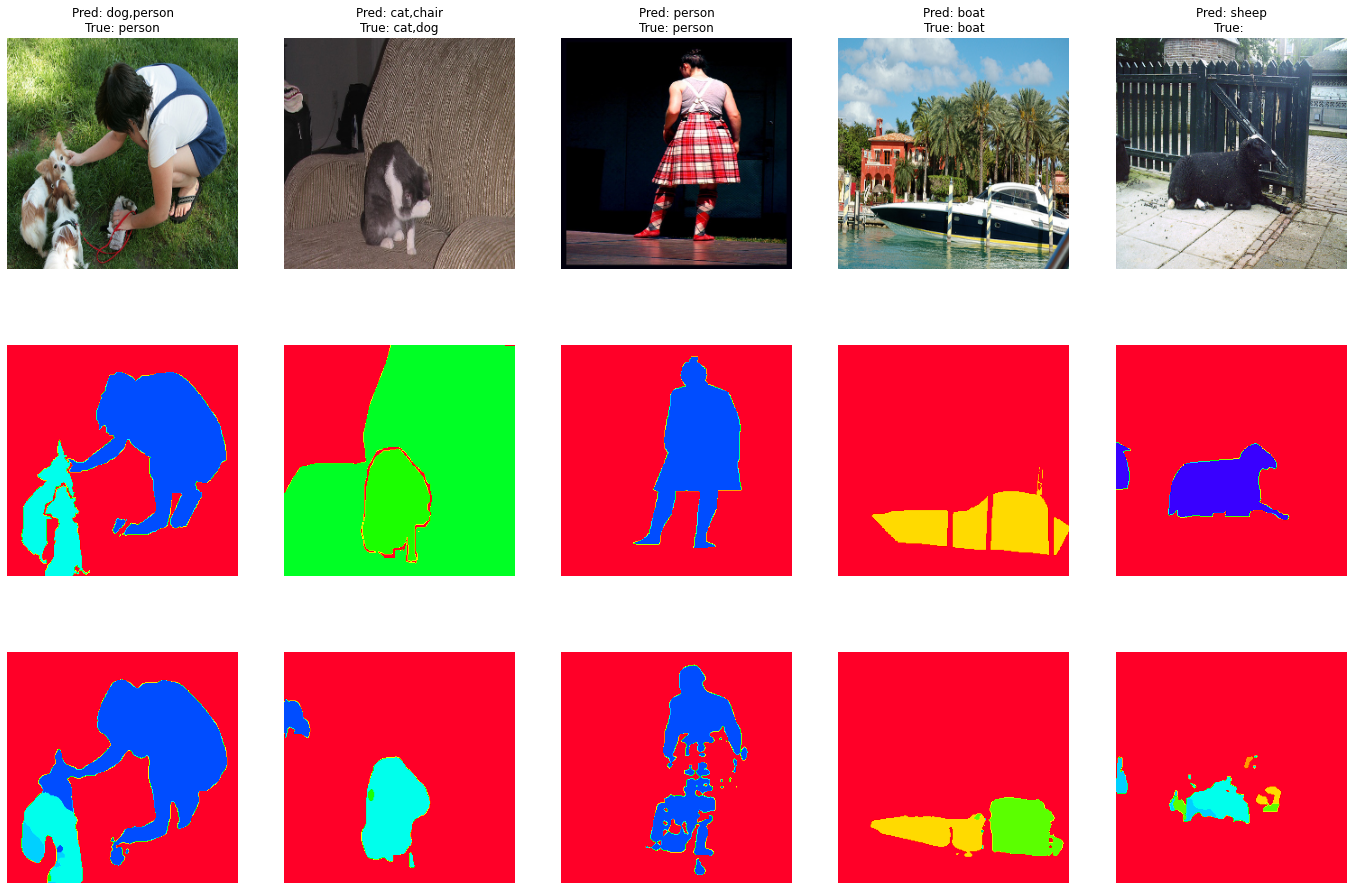

In [64]:
plotdisplay_bad(0)

## Classification performance

We first look at the confusion matrix

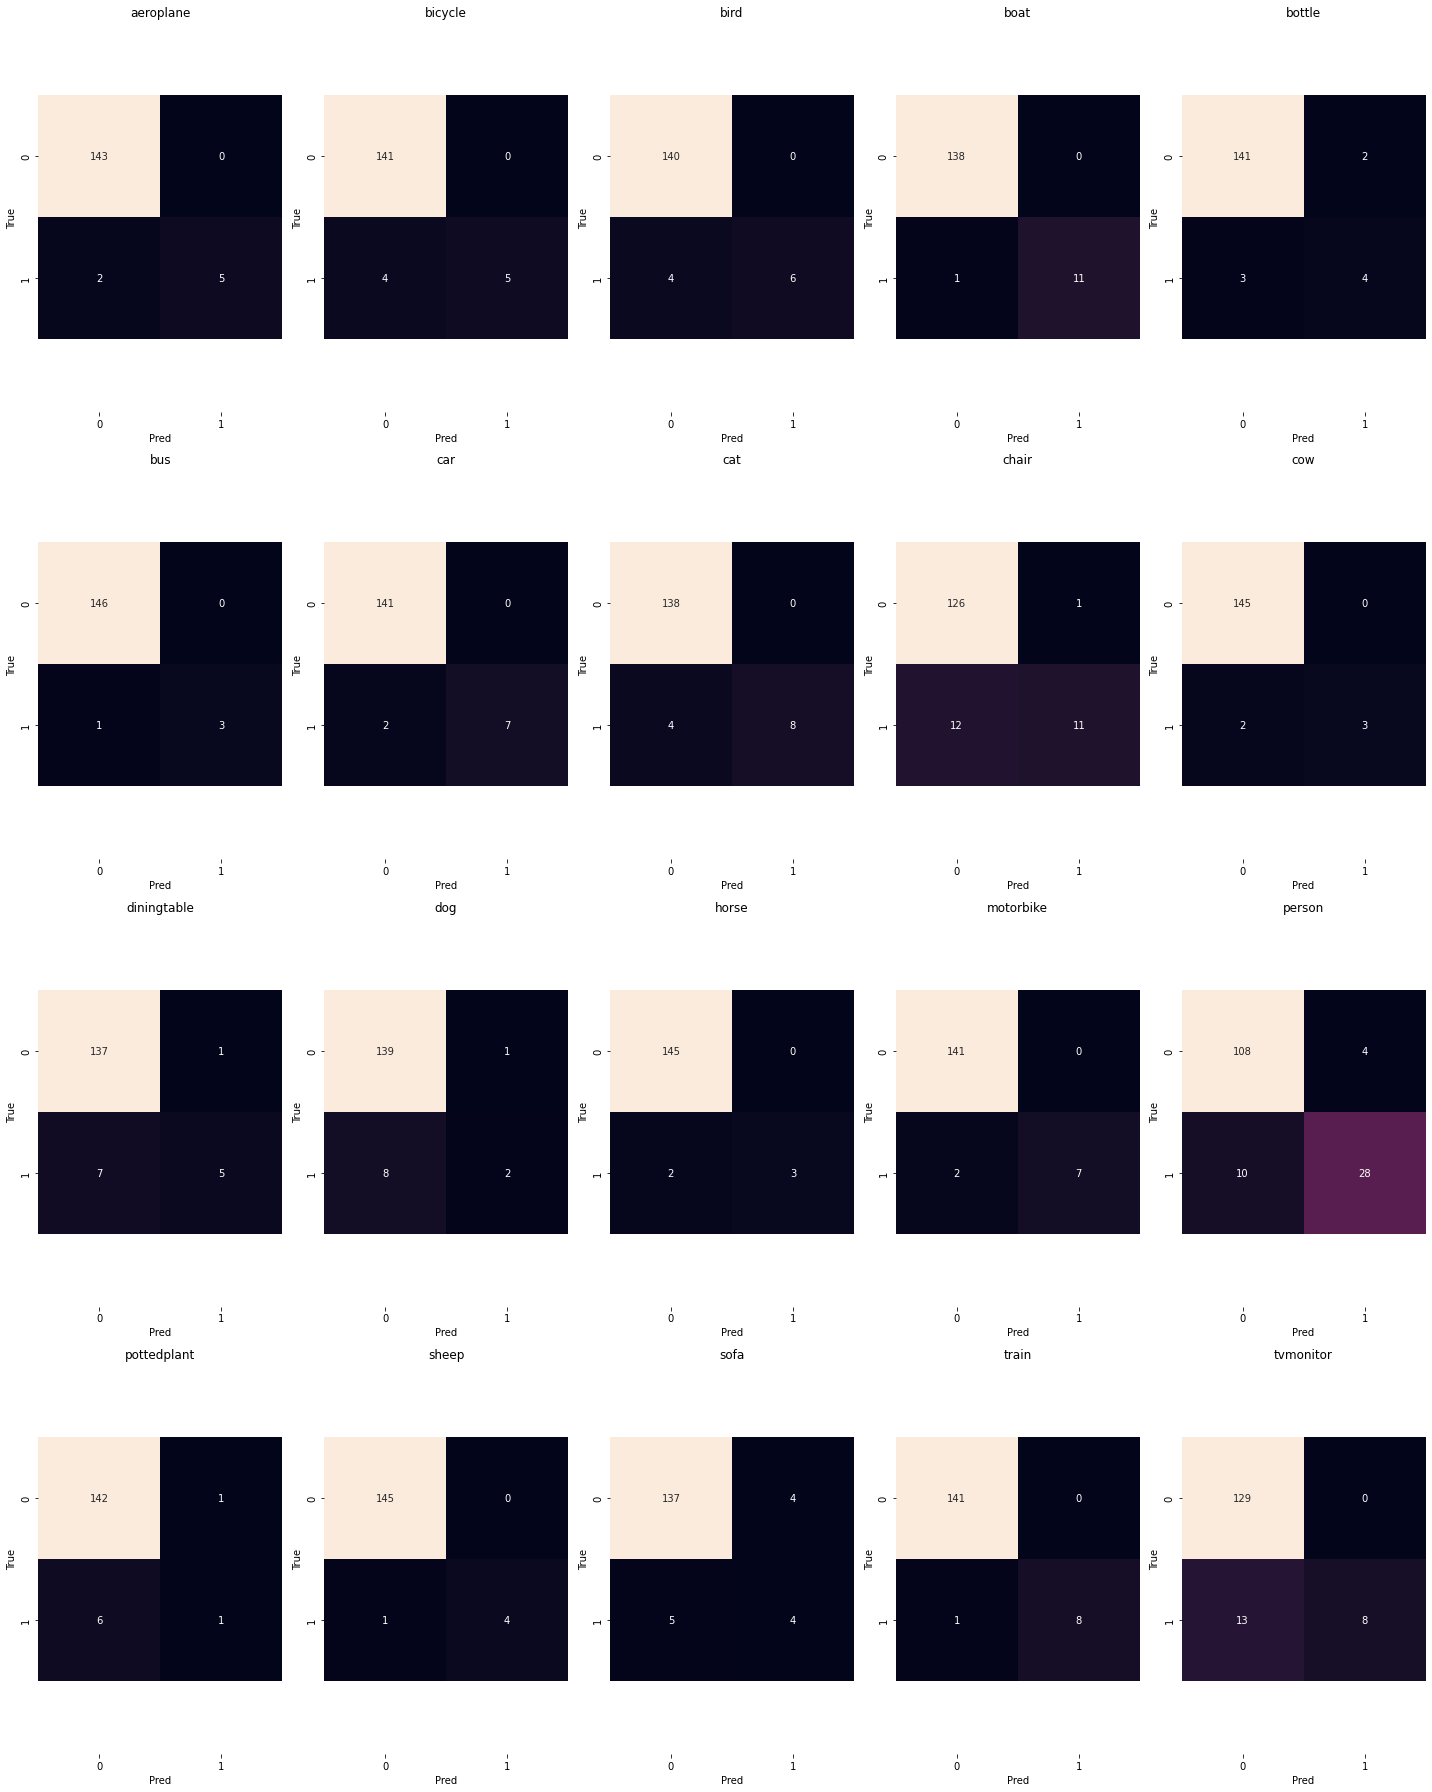

In [65]:
fig = plt.figure(figsize=(4*5,5*5))
ax = fig.subplots(4,5)
ax = ax.flatten()
cm1 = multilabel_confusion_matrix(yCat_test,catPred)
for a,c,l in zip(ax,cm1,labels):
    sns.heatmap(c,ax=a,annot=True,fmt='g',cbar=False)
    a.axis('equal')
    a.set_title(l)
    a.set_xlabel('Pred')
    a.set_ylabel('True')
plt.tight_layout()

In [108]:
def getStatus(intrue,inpred):
    if intrue & inpred:
        return "True Pos"
    if ~intrue & inpred:
        return "False Pos"
    if intrue & ~inpred:
        return "False Neg"
    if ~intrue & ~inpred:
        return "True Neg"
    
def getCategoryPlotter(Ximg,yCat_true,yCat_pred):
    def plotCategory(category,figsize,shape):
        col = np.array(labels) == category
        c1,_ = np.where( yCat_test[:,col] )
        c2,_ = np.where( catPred[:,col] )
        c =  list( set(c1).union(set(c2)) )
        
        fig = plt.figure(figsize=figsize)
        ax = fig.subplots(shape[0],shape[1])
        ax = ax.flatten()
        
#        status = {[True,True]:"True Pos",[False,True]:"False Pos",[True,False]:"False Neg"}
        for i in range(shape[0]*shape[1]):
            ax[i].imshow(Ximg_test[c][i])
            ax[i].axis('off')
            
            intrue = c[i] in c1
            inpred = c[i] in c2
            
            str1 = "Pred: " + ",".join( list(np.array(labels)[yCat_pred[c[i]]==1]))
            str2 = "True: " + ",".join( list(np.array(labels)[yCat_true[c[i]]==1]))
            ax[i].set_title(str1 + "\n" + str2 + "\n" + getStatus(intrue,inpred) )
    return plotCategory

categoryPlotter = getCategoryPlotter(Ximg_test,yCat_test,catPred)

In terms of bicycles we find several true positives when the bicycle appears clear in the image but we misclassify some of them. We find several False Negatives when the bikes are not that clear to the human eye, or at the edge of the frame

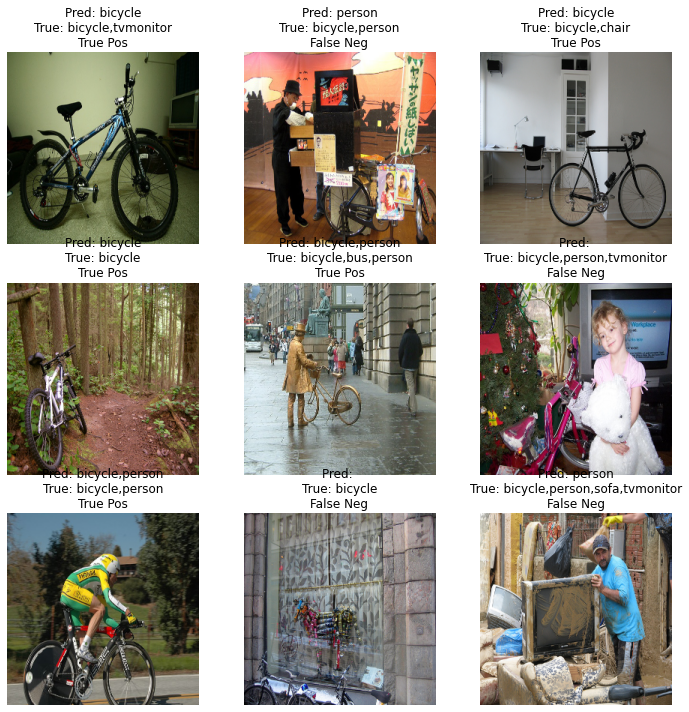

In [109]:
categoryPlotter('bicycle',(12,12),(3,3))

In terms of people, we see that in general we detect people when these appear very clear to the human eye. Notice that in one of the images we can just appreciate one hand so if would be super difficult to classify that one, for example the hand petting the cat on the first row, or the driver of the car in the last row. We see as well some False Negatives in the image of the boat since the person is almost imperceptible to the human eye.

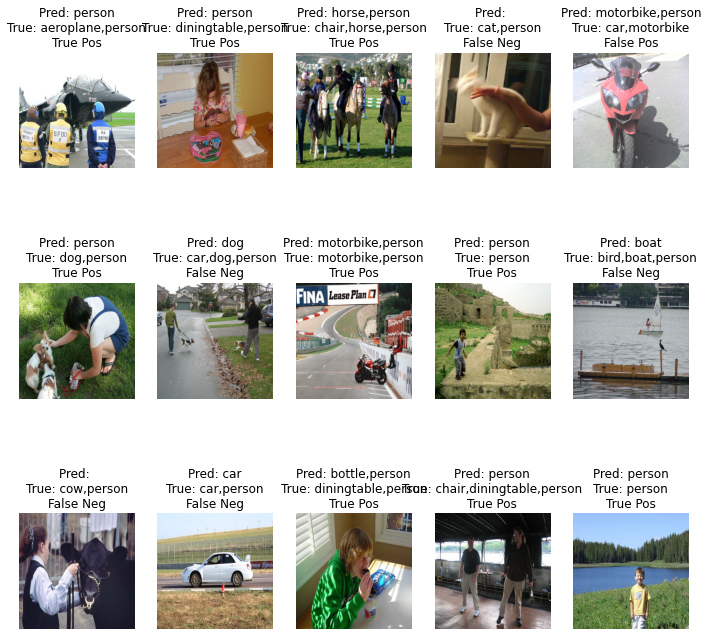

In [110]:
categoryPlotter('person',(12,12),(3,5))

# Preparing the final submission

Load the competition data

In [68]:
submission_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/test/test_set.csv', index_col="Id")
submission_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/test/img/test_{}.npy'.format(idx)) for idx, _ in submission_df.iterrows()]

Resize to the shapes, to the sizes needed by our network.

In [69]:
IMG_SIZE = 256
submission_shapes = submission_df['img'].apply(lambda img: img.shape) # Keep the original shapes
submission_df['img']=submission_df['img'].apply(lambda img: cv2.resize(img,(IMG_SIZE,IMG_SIZE)))
submission_imgs = np.stack(submission_df['img'],axis=0)
labels = list( submission_df.columns[0:-1] )

Load the final models and make the predictions. These have been trained on the (train+test)+augmentations described earlier.

First the classification

In [70]:
class_model = tf.keras.models.load_model("/kaggle/input/classification-models/classification_aug2")
submission_class = class_model.predict(submission_imgs)
submission_class = np.round(submission_class)
del class_model

Then the segmentation, resizing the segmentation masks back to their original size

In [71]:
seg_model = tf.keras.models.load_model("/kaggle/input/segmentation-models/results_jacob2/unet_transfer_256_submission",compile=False)

In [72]:
submission_seg = []
for i in range(len(submission_imgs)):
    pred = seg_model.predict(submission_imgs[[i]])
    submission_seg.append( np.argmax(pred,axis=3) )#.astype(np.uint8).flatten().reshape((IMG_SIZE,IMG_SIZE))
submission_seg = np.concatenate(submission_seg,axis=0)
submission_seg_resize = [cv2.resize(seg,shape[0:2],interpolation=cv2.INTER_NEAREST) for seg,shape in zip(submission_seg,submission_shapes)]

In [73]:
submission_df['seg'] = submission_seg_resize
submission_df[labels] = submission_class

In [74]:
submission_seg_resize[1].shape

(500, 415)

## Inspect our submission

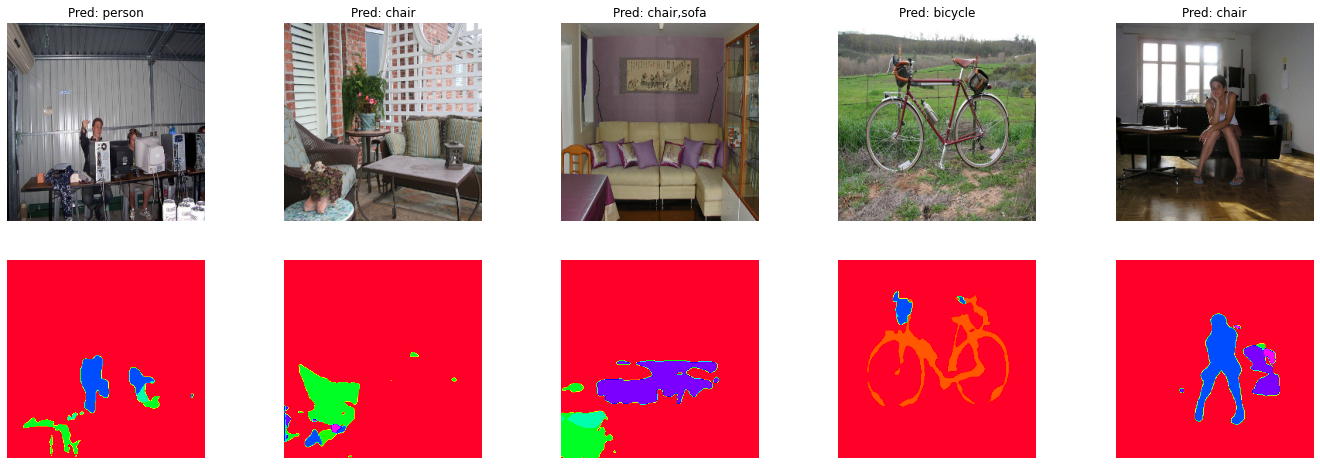

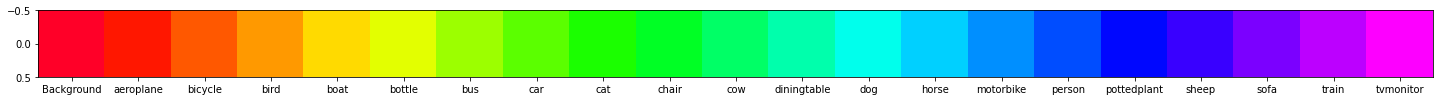

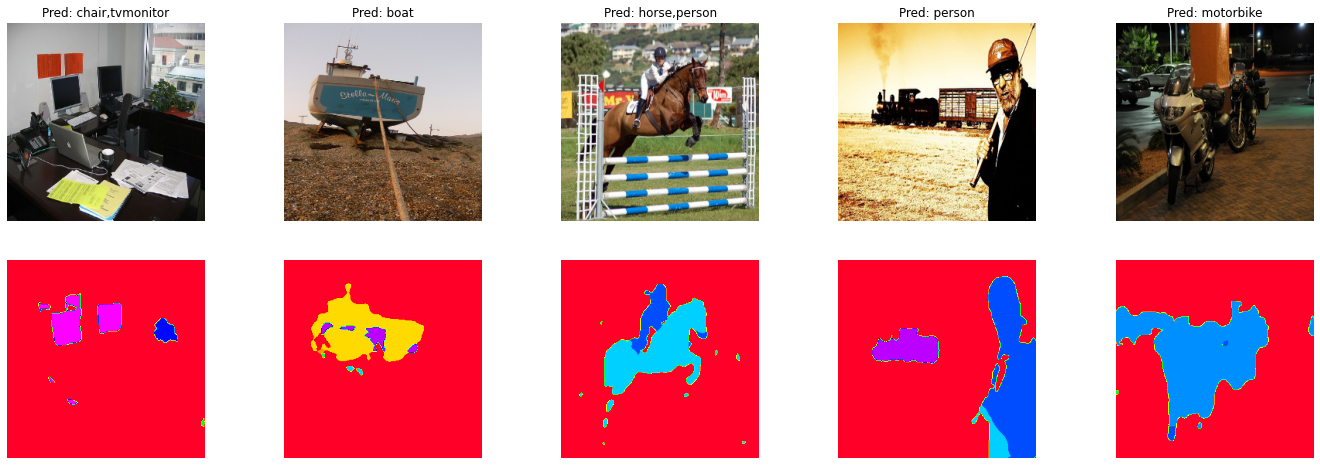

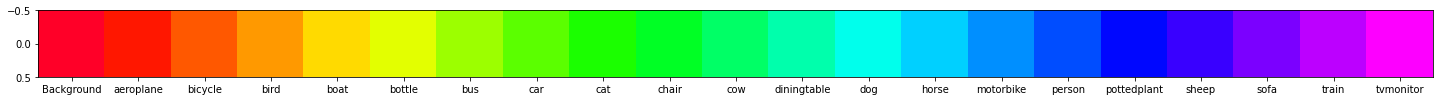

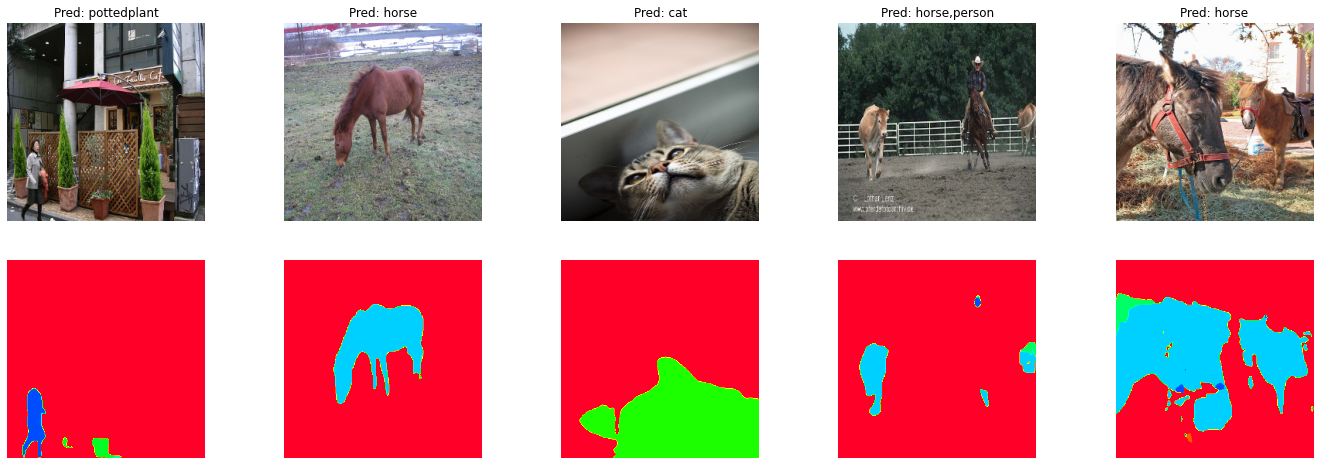

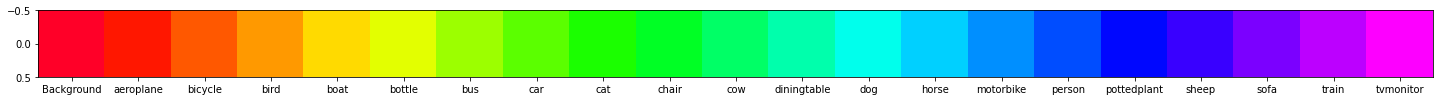

In [76]:
def plotKey():
    fig = plt.figure(figsize=(25,2))
    ax = fig.subplots(1,1)
    ax.imshow(np.atleast_3d(np.arange(0,21)),vmin=0,vmax=21)
    ax.set_xticks(np.arange(0,21))
    a = ax.set_xticklabels(['Background'] + labels)
    
def getPlotDisplay(xImg,ySeg_pred,cat_pred):
    def plotAtOffset(offset=0):
        N = 5
        fig = plt.figure(figsize=(24,8))
        ax = fig.subplots(2,N)
        for i in range(N):
            ii = i+offset
            ax[0,i].imshow(xImg[ii])
            ax[1,i].imshow(ySeg_pred[ii],vmin=0,vmax=21)
            ax[0,i].axis('off')
            ax[1,i].axis('off')
            pred_str = "Pred: " + ",".join( list(np.array(labels)[cat_pred[ii]==1]))
            ax[0,i].set_title(pred_str)
    return plotAtOffset

plot_display = getPlotDisplay(submission_imgs,submission_seg,submission_class)
plot_display()
plotKey()
plot_display(5)
plotKey()
plot_display(10)
plotKey()

## Generating the submission CSV

The segmentation maps need to be run-length encoded.

In [77]:
def _rle_encode(img):
    """
    Kaggle requires RLE encoded predictions for computation of the Dice score (https://www.kaggle.com/lifa08/run-length-encode-and-decode)

    Parameters
    ----------
    img: np.ndarray - binary img array
    
    Returns
    -------
    rle: String - running length encoded version of img
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    return rle

def generate_submission(df):
    """
    Make sure to call this function once after you completed Sect. 2 and Sect. 3! It transforms and writes your test dataframe into a submission.csv file.
    
    Parameters
    ----------
    df: pd.DataFrame - filled dataframe that needs to be converted
    
    Returns
    -------
    submission_df: pd.DataFrame - df in submission format.
    """
    df_dict = {"Id": [], "Predicted": []}
    for idx, _ in df.iterrows():
        df_dict["Id"].append(f"{idx}_classification")
        df_dict["Predicted"].append(_rle_encode(np.array(df.loc[idx, labels])))
        df_dict["Id"].append(f"{idx}_segmentation")
        df_dict["Predicted"].append(_rle_encode(np.array([df.loc[idx, "seg"] == j + 1 for j in range(len(labels))])))
    
    submission_df = pd.DataFrame(data=df_dict, dtype=str).set_index("Id")
    #submission_df.to_csv("submission.csv")
    return submission_df

In [78]:
toKaggle = generate_submission(submission_df)
toKaggle.to_csv("submission.csv")

# Adversial attack

In [111]:
train_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/train_set.csv', index_col="Id")
labels = train_df.columns
train_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/img/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
train_df["seg"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/seg/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
print("The training set contains {} examples.".format(len(train_df)))

The training set contains 749 examples.


In [112]:
IMG_SIZE = [256,256]
train_df['img'] = train_df['img'].apply(lambda img: cv2.resize(img,IMG_SIZE))
train_df['seg'] = train_df['seg'].apply(lambda img: cv2.resize(img,IMG_SIZE))

In [113]:
# Split 20% off for the test data
train_data, test_data = train_test_split(train_df,test_size = 0.2,shuffle=True,random_state = 0)
# Split 25% off the train data to use as validation (0.25 x 0.8 = 0.2)
train_data, val_data = train_test_split(train_data,test_size = 0.25,shuffle=True,random_state = 1)
print(f" Ntrain {len(train_data.index)}")
print(f" Ntest  {len(test_data.index)}")
print(f" Nval   {len(val_data.index)}")


 Ntrain 449
 Ntest  150
 Nval   150


In [114]:
def extractImgSegCat(df):
    img = np.stack( df["img"], axis=0 )
    seg = np.stack( df["seg"], axis=0 )
    cat = df.drop(labels=['img','seg'],axis=1 )
    return img,seg,cat

Ximg_train,ySeg_train,yCat_train = extractImgSegCat(train_data)
Ximg_test ,ySeg_test ,yCat_test  = extractImgSegCat(test_data)
Ximg_val  ,ySeg_val  ,yCat_val   = extractImgSegCat(val_data)

# Adversarial attack

Several methods exist for adversarial attacks. In essence the simplest one is the fast sign gradient method. All it needs is for a cost function to be specified, afterwards the output of the model can be taken as input to an objective function. That allows the gradients to be computed with respect to the original image. Afterwards any first or second order optimisation method can be used, e.g. gradient descent with momentum to produce noise that misclassifies an image. [Goodfellow, I. J., Shlens, J., & Szegedy, C. (2014). Explaining and harnessing adversarial examples. arXiv preprint arXiv:1412.6572.](https://arxiv.org/abs/1412.6572)

FGSM has two weakness though:

1. The procedure needs to be repeated for each image. This is what is meant with the **iterative** nature of this attack.
2. The procedure is quite slow.

In this section we propose a procedure that is heavily inspired by both the project brief and a recent paper. [Poursaeed, O., Katsman, I., Gao, B., & Belongie, S. (2018). Generative adversarial perturbations. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 4422-4431).](https://openaccess.thecvf.com/content_cvpr_2018/papers/Poursaeed_Generative_Adversarial_Perturbations_CVPR_2018_paper.pdf)

On a high level the procedure goes as follows:

* Step 0: The classifier. We train a classifier and/or segmentation model that we will attack. We chose to attack our Xception based classifier. We will not cover a detailed explanation of the model as this is already covered above.
* Step 1: Training the Convolutional Autoencoder
* Step 2: Defining the loss function and reguralisation term
* step 3: Defining the task and the pipeline
* Step 4: Evaluation

In [115]:
x_train = Ximg_train / 255.
x_val = Ximg_val / 255.
x_test = Ximg_test / 255.

## Step 1: The Convolutional Autoencoder

### Key principles

Autoencoders are a type of machine learning algorithm that are capable of compressing input. They function by taking an input and gradually shinking it until a so called information bottleneck. Afterwards the input is expanded from the bottleneck onwards while trying to minimise the reconstruction loss, the difference between the input and the output.

We use autoencoders to move from the iterative procedure to a **generative** approach. Although autoencoders are not considered generative models we could use them to produce image dependent noise to influence the classifiers. After this procedure is carried out, the idea is that given an input image the autoencoder can produce a specific pattern that lets the image be misclassified. 

**In our approach we train the autoencoder separately. Freeze the encoder and apply transfer learning on the decoder.** The idea is that first a latent representation is learnt of the input. We then ask it to produce noise based on this latent representation. The stagewise approach of training the autoencoder also simplifies the attack.


### Our chosen architecture

The chosen architecture of the autoencoder had inspiration from three main sources:

1. A 2014 paper on Convolutional neural network architectures that covers the fact that CNN's can entirely be built out of convolutional layers. [Springenberg, J. T., Dosovitskiy, A., Brox, T., & Riedmiller, M. (2014). Striving for simplicity: The all convolutional net. arXiv preprint arXiv:1412.6806.](https://arxiv.org/abs/1412.6806)
2. The UNET architecture as described in the previous sections.
3. [A lecture of the University of Amsterdam on convolutional autoencoders.](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html)

Our main goal was keeping the architecture as simple as possible. The first paper gave us insight into how we could do that. The intuition behind convolutional neural networks is that throughout the network the resolution of the image is reduced, while the amount of (hierarcical) features is increase incrementally. In the first layer the neurons look for gabor-like features (cfr. the lectures) and in higher levels these are combined. **Resolution reduction usually happens with max or average pooling. In our architecture we do it with stride convolutions.** The idea behind strided convolutions, not to be confused with dilated convolutions, is that only half of the image is convolved around. By adding the correct amount of padding this operation can be used to exactly halve the size of the input image. For reference, we used the following formula:

![](https://i.stack.imgur.com/vD1u3.png)
 
Afterwards the used UNET as a source of inspiration as to how to arrange the convolutions. We group them in blocks of three where the first one is a strided convolution. The following two are are same convolutions. Afterwards the resolution is dropped again. **The input image is iteratively reduced from 256 x 256 x 3 to 32 x 32 x 64 in the information bottle neck which represent a compression ratio of 2/3rd.**

The decoder has exactly the same architecture, but with strided transposed convolution operations. With these the inputs are doubled while going through the network. Between each of these two same convolutions are applied. In the final layer a sigmoid activation function is used to ensure that the output is bound between 0 and 1..

**Batch normalization is used together with a LeakyRelu activation function to smoothen the procedure of training.** The network can be trained with either the mean squared error or binary cross entropy as an objective function. We received better performance while training with BCE. **More complex architectures such as skip connections between the same convolutions were also considered but did not result in better performance.** Autoencoders can leverage existing ideas from architectures such as Resnet or Xception. We chose to keep the architecture simple as it already provided reasonable results.
 
All things considered this results in a network that has around 450.000 parameters.

In [116]:
classifier = keras.models.load_model('../input/classifier/classifier_adv.h5')

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder (Sequential)         (None, 32, 32, 64)        224448    
_________________________________________________________________
decoder (Sequential)         (None, 256, 256, 3)       251951    
_________________________________________________________________
tf.math.sigmoid_4 (TFOpLambd (None, 256, 256, 3)       0         
Total params: 476,399
Trainable params: 474,537
Non-trainable params: 1,862
_________________________________________________________________


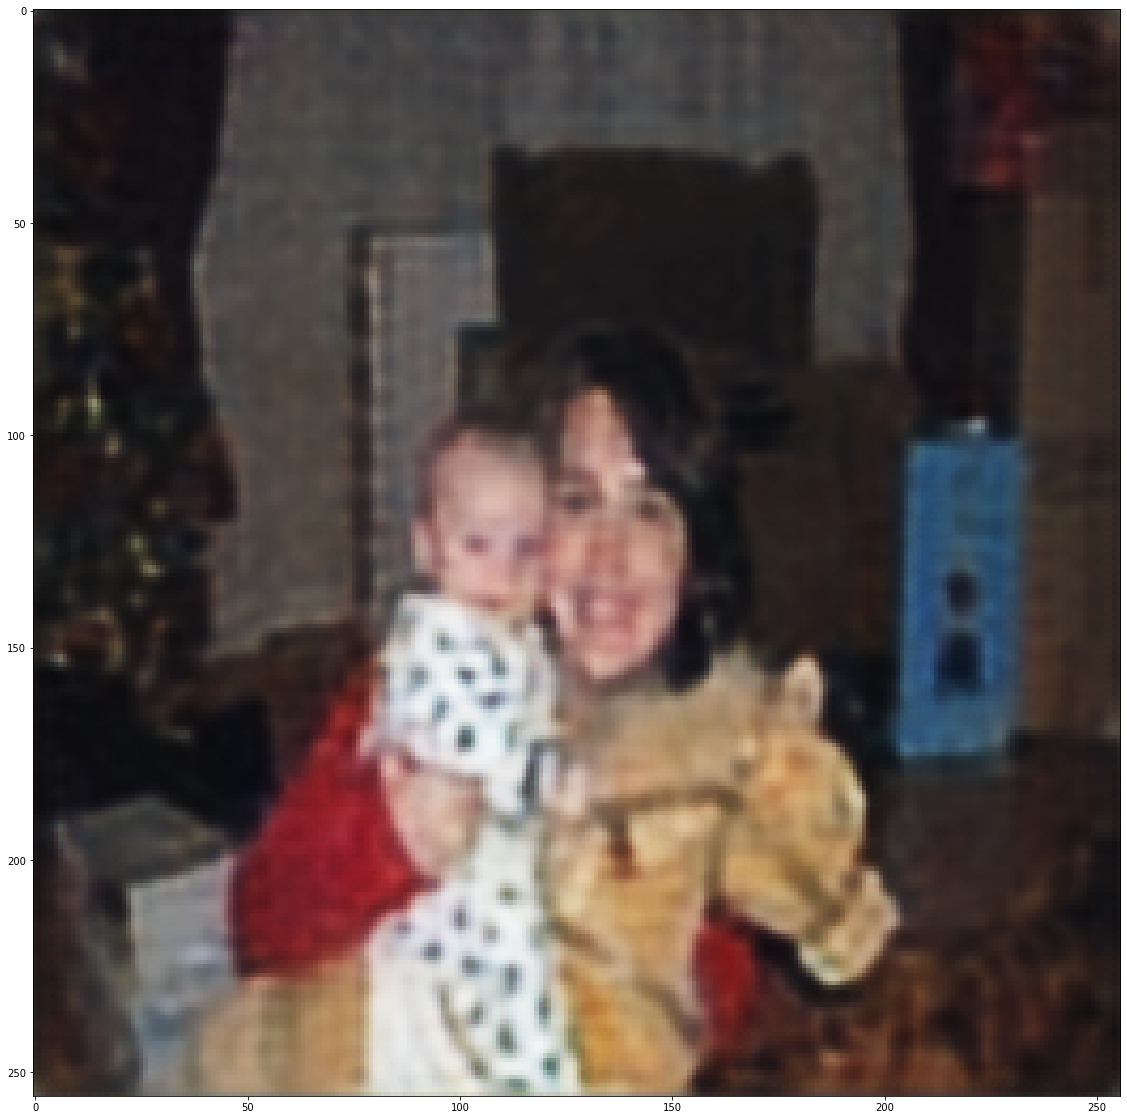

In [120]:
class ConvAutoEncoder(keras.Model):
    def __init__(self, KernelSize=(3,3), act_fn= keras.layers.LeakyReLU, name="Autoencoder"):
        super(ConvAutoEncoder, self).__init__(name=name)        
        
        self.encoder = keras.Sequential([
                                        keras.layers.Conv2D(32, kernel_size = KernelSize, strides=(2,2), padding="same"),
                                        keras.layers.BatchNormalization(),
                                        act_fn(),
            
                                        keras.layers.Conv2D(32, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                        keras.layers.BatchNormalization(),
                                        act_fn(),
            
                                        keras.layers.Conv2D(32, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                        keras.layers.BatchNormalization(),
                                        act_fn(),
        
        
                                        keras.layers.Conv2D(64, kernel_size = KernelSize, strides=(2,2), padding="same"),
                                        keras.layers.BatchNormalization(),
                                        act_fn(),
            
                                        keras.layers.Conv2D(64, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                        keras.layers.BatchNormalization(),
                                        act_fn(),
            
                                        keras.layers.Conv2D(64, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                        keras.layers.BatchNormalization(),
                                        act_fn(),
            
        
                                        keras.layers.Conv2D(64, kernel_size = KernelSize, strides=(2,2), padding="same"),
                                        keras.layers.BatchNormalization(),
                                        act_fn(),
            
                                        keras.layers.Conv2D(64, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                        keras.layers.BatchNormalization(),
                                        act_fn(),
            
                                        keras.layers.Conv2D(64, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                        keras.layers.BatchNormalization(),
                                        act_fn(),], name="encoder") # 32 x 32 x 64 => 1/3
        
        
        
        
        self.decoder = keras.Sequential([
                                    keras.layers.Conv2DTranspose(64, kernel_size = KernelSize, strides=(2,2), padding="same"),
                                    keras.layers.BatchNormalization(),
                                    act_fn(),

                                    keras.layers.Conv2D(64, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                    keras.layers.BatchNormalization(),
                                    act_fn(),
            

                                    keras.layers.Conv2D(64, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                    keras.layers.BatchNormalization(),
                                    act_fn(),
            
                                    keras.layers.Conv2DTranspose(64, kernel_size = KernelSize, strides=(2,2), padding="same"),
                                    keras.layers.BatchNormalization(),
                                    act_fn(),
            

                                    keras.layers.Conv2D(64, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                    keras.layers.BatchNormalization(),
                                    act_fn(),

                                    keras.layers.Conv2D(64, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                    keras.layers.BatchNormalization(),
                                    act_fn(),
            
                                    keras.layers.Conv2DTranspose(32, kernel_size = KernelSize, strides=(2,2), padding="same"),
                                    keras.layers.BatchNormalization(),
                                    act_fn(),
            

                                    keras.layers.Conv2D(32, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                    keras.layers.BatchNormalization(),
                                    act_fn(),

                                    keras.layers.Conv2D(3, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                    keras.layers.BatchNormalization()
                                    ], name = "decoder")
                

        
    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.decoder(x)
        return keras.activations.sigmoid(x)
    
    def build_graph(self, raw_shape):
        x = tf.keras.layers.Input(raw_shape)
        return tf.keras.Model(inputs=[x], 
                                  outputs=self.call(x))


autoencoder = ConvAutoEncoder()
autoencoder.build_graph(IMG_SIZE+[3]).summary()

autoencoder.compile(
          optimizer=keras.optimizers.Adam(learning_rate = 3e-4),
          loss=keras.losses.BinaryCrossentropy(),
          metrics= ['accuracy'])

# autoencoder.fit(x_train, x_train,
#                 batch_size= 16,
#                             epochs=250, verbose=1,
#                             validation_data=(x_val,x_val),
#                             callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

# autoencoder.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
#               loss=keras.losses.BinaryCrossentropy(),
#               metrics=['accuracy'])
# autoencoder.summary()

# history = autoencoder.fit(np.vstack([x_train, x_val]), np.vstack([x_train,x_val]),
#                             batch_size= 32,
#                             epochs=10, verbose=1)

autoencoder = keras.models.load_model("../input/adversarialattack/results (1)/autoencoder.tf")
images = autoencoder.predict(x_val)
plt.imshow(images[0])

## Step 2: Defining the loss function and reguralisation term

### The loss function

Conceptually the loss function is something of the form: 
$$ \min L + \lambda * \lVert Noise \rVert $$

with $L$ being $MSE$ or $BCE$. This opens three additional questions: 

1. What loss function will be used?
2. What vector norm will be used?
3. How do we set $\lambda$?


#### BCE VS MSE

We tried out both $BCE$ and $MSE$ but the former gave empirically better results. Mean squared error did not work as well.

#### The vector norm

The $L_{2}$ norm produced the best resutls for us, however we understand the difference that both vector norms encode. The $L_{\infty}$ should 'punish' large magnitude noise. That makes intuitive sense as the pieces of noise we should perceive the most are high intensities when summing over the three channels. We however produced the best results when using the $L_{2}$ norm.


#### Setting lambda

$\lambda$ modulates how much weight is given to either classifying the deceptive labels or reducing the amount of noise added to the image. **We used the following simple heuristic to tune how much it should be set to:**

$$ \lambda = \frac{1}{W * H * channels} $$

The intuition behind the heuristic is that both $MSE$ and $BCE$ are spaced between 0 and 1. With the transformation outlined above if all pixels channels are set to one the resulting $L_{2} = 256 * 256 * 3$ and when multiplied by $\lambda = 5.0862630208333333333333333333333e^{-6}$ it equals 1. **This ensures that both the $L$ and the $R$ term are on the same scale. This number can be tuned with a hyperparameter search but we deemed this out of scope for this assignment.**

In [121]:
class NoiseReguralisation(keras.layers.Layer):
    
    def __init__(self, rate=0.5): # Rate is lambda
        super(NoiseReguralisation, self).__init__()
        self.rate = rate

    def call(self, inputs):
        self.add_loss(self.rate * tf.reduce_sum(tf.square(inputs)))
        return inputs

## Defining the task and pipeline

### The task: making aeroplanes appear where they are not

We do this by handing the model one vector called $y_dec$ and having it minimise the loss function as explained previously with respect to that. We essentially ask the model to keep correctly classifying images as aeroplanes when they are not and to classify non-aeroplanes as aeroplanes. The second term in the loss function forces the model to do this by introducing as little noise as possible. This also means that $distance(image_{original}, image_{peturbed})$ is minimal. 

In [124]:
y_dec_train = np.ones(yCat_train.shape[0])
y_dec_val = np.ones(yCat_val.shape[0])

### The model

**For our attack we first trained a classifier and an autoencoder separately. Afterwards we froze the classifier and the encoder. During training we simply update the decoder to produce the specific noise we want**

This procedure ensures that only 250000 parameters need to be updated. **Since this is a whitebox attack we can benefit from simply computing the gradient after the classifier and using backpropagation through the classifier into the decoder.** In essence, this is a form of transfer learning, the decoder is re-trained to output the noise necessary to fool a classifier. The code below shows how the procedure is done. Training this procedure can take upwards of 200-300 epochs. The first few epochs have a high loss and are most likely spent reducing the output of the autoencoder. It's advisable to train this network with early stopping.

The procedure described is somewhat similar to [Poursaeed, O., Katsman, I., Gao, B., & Belongie, S. (2018). Generative adversarial perturbations. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 4422-4431).](https://openaccess.thecvf.com/content_cvpr_2018/html/Poursaeed_Generative_Adversarial_Perturbations_CVPR_2018_paper.html) however there are noticeable differences between our approach and theirs. The training procedures is noticeably different, they do not have a reguralisation term in the loss function but rather use scaling and clipping. **It is important to note that their approach also results in human visible perturbations.**


In [127]:
class AdversarialAttack(keras.Model):
    def __init__(self, classifier, autoencoder, attacked_class, rate, name="AdversarialAttack"):
        super(AdversarialAttack, self).__init__(name=name)
        
        self.classifier = classifier
        self.autoencoder = autoencoder
        self.attacked_class = attacked_class
        self.noiseReguralisation = NoiseReguralisation(rate)
        
        self.classifier.trainable = False
        self.autoencoder.get_layer(name="encoder").trainable = False
       
    
    def call(self, inputs):
        original_images = inputs
        x = self.autoencoder(inputs)
        x = self.noiseReguralisation(x)
        x = keras.layers.Add()([x, original_images])
        x =  self.classifier(x)[:,self.attacked_class]
        return x
    
    def return_noise(self, inputs):
        return self.autoencoder.predict(inputs)
    
    def return_attacker(self):
        return self.autoencoder
    
    def build_graph(self, raw_shape):
        x = tf.keras.layers.Input(raw_shape)
        return tf.keras.Model(inputs=[x], 
                                  outputs=self.call(x))
    

attacker = AdversarialAttack(classifier, autoencoder, 0, 5.0862630208333333333333333333333e-6)

attacker.build_graph(IMG_SIZE+[3]).summary()
attacker.compile(optimizer=keras.optimizers.Adam(learning_rate = 3e-4),
          loss=keras.losses.BinaryCrossentropy())

attacker_weights = keras.models.load_model("../input/adversarialattack/results (1)/adversarial.tf")

attacker.set_weights(attacker_weights.get_weights())

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Autoencoder (ConvAutoEncoder)   (None, 256, 256, 3)  476399      input_11[0][0]                   
__________________________________________________________________________________________________
noise_reguralisation_3 (NoiseRe (None, 256, 256, 3)  0           Autoencoder[2][0]                
__________________________________________________________________________________________________
add_15 (Add)                    (None, 256, 256, 3)  0           noise_reguralisation_3[0][0]     
                                                                 input_11[0][0]             

In [ ]:
# attacker.fit(x_train, y_dec_train,
#                 batch_size= 16,
#                             epochs=250, verbose=1,
#                             validation_data=(x_val,y_dec_val),
#                             callbacks=[tf.keras.callbacks.EarlyStopping(patience=25)])

In [128]:
noise = attacker.return_noise(x_val)

In [129]:
plt.rcParams['figure.figsize'] = [20, 20]

## Results

As you can see below the perturbations are human visible. **It is important to note that continuing training with a smaller learning rate and/or tuning $\lambda$ might both lead to less visible noise**.

The attack is not so realistic as the amount of noise added can clearly be seen by someone. Secondly, we had white-box access to the model which is very rare. We do not expect such scenario's to occur frequently.

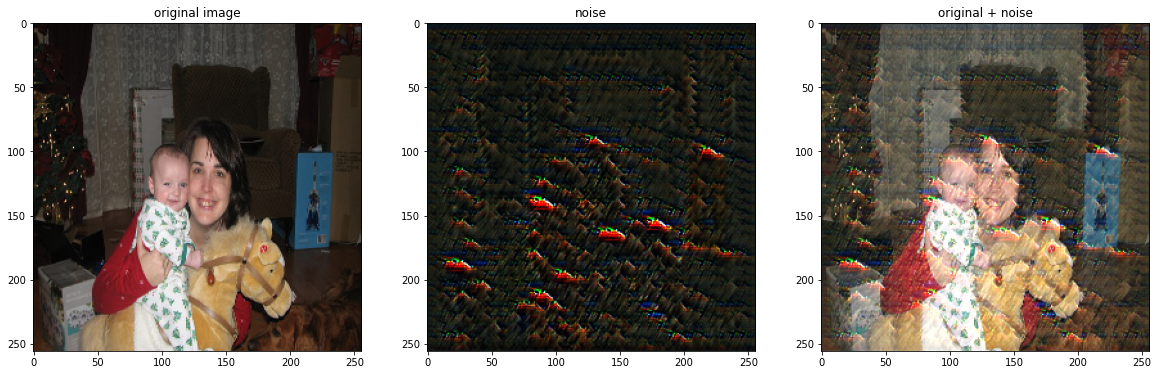

In [130]:
def plot_example(index):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)


    ax1.set_title("original image")
    ax1.imshow(x_val[index])  
    ax2.set_title("noise")

    ax2.imshow(noise[index])
    ax3.set_title("original + noise")

    ax3.imshow(x_val[index] + noise[index]) 

plot_example(0)

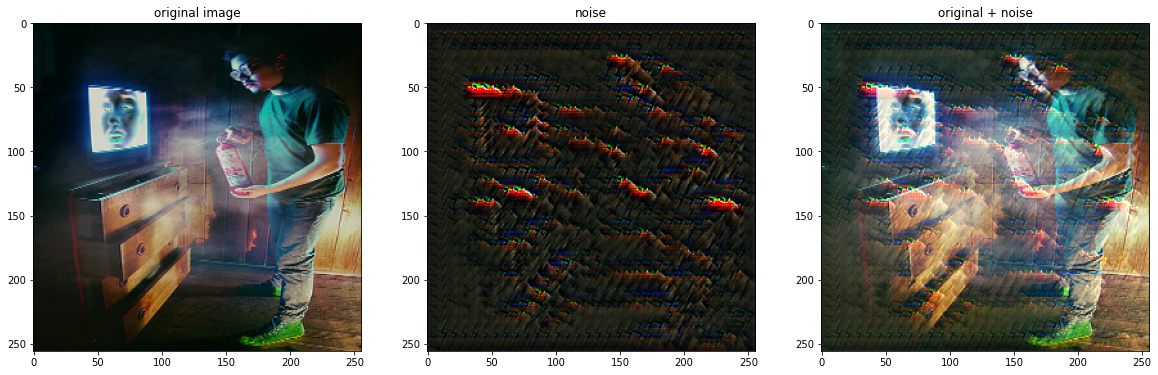

In [131]:
plot_example(10)

In the image below a confusion matrix between the testing set and the attacker are shown. **This indicates that the model is able to attack images it was not trained on. Only 8 images were not classified as aeroplanes on the hold-out set.** This strongly implies this attack can be carried out on random images as well. 

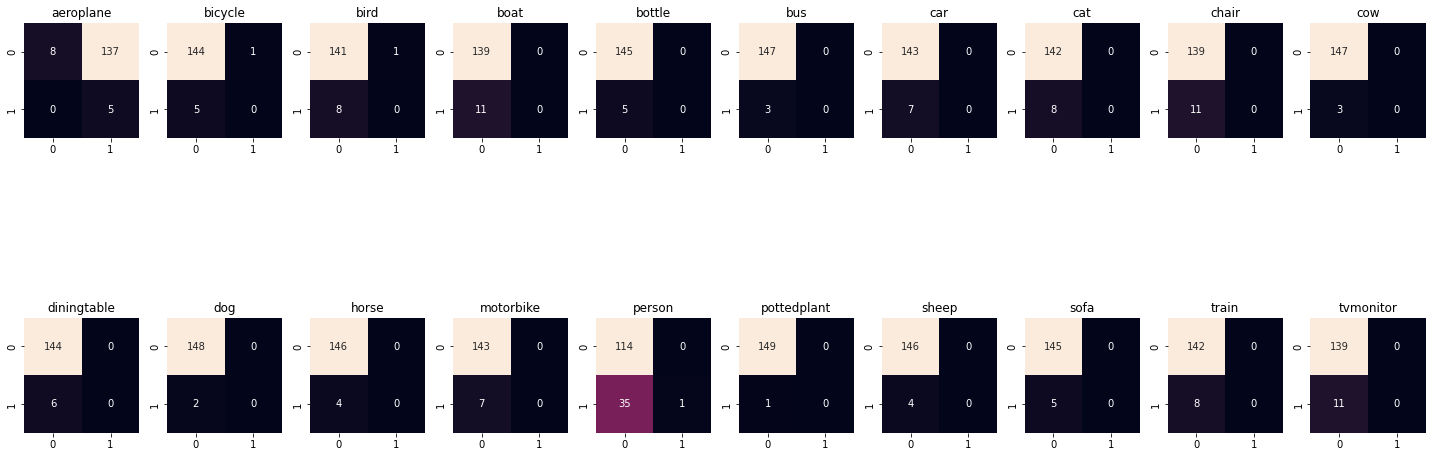

In [132]:
noise_test = attacker.return_noise(x_test)
y_test = classifier.predict(x_test)
y_test = y_test.round()
noisy_predictions = classifier.predict(x_test + noise_test)
noisy_predictions = noisy_predictions.round()

CM = multilabel_confusion_matrix(y_test, noisy_predictions)

labels = yCat_test.columns

fig = plt.figure(figsize=(20,10))
ax = fig.subplots(2,10)
ax = ax.flatten()
for l,c,a in zip(labels,CM,ax):
    sns.heatmap(c, annot=True,ax=a,cbar=False,fmt="g") # font size\
    a.set_title(l)
    a.set_aspect('equal', 'box')

plt.tight_layout()

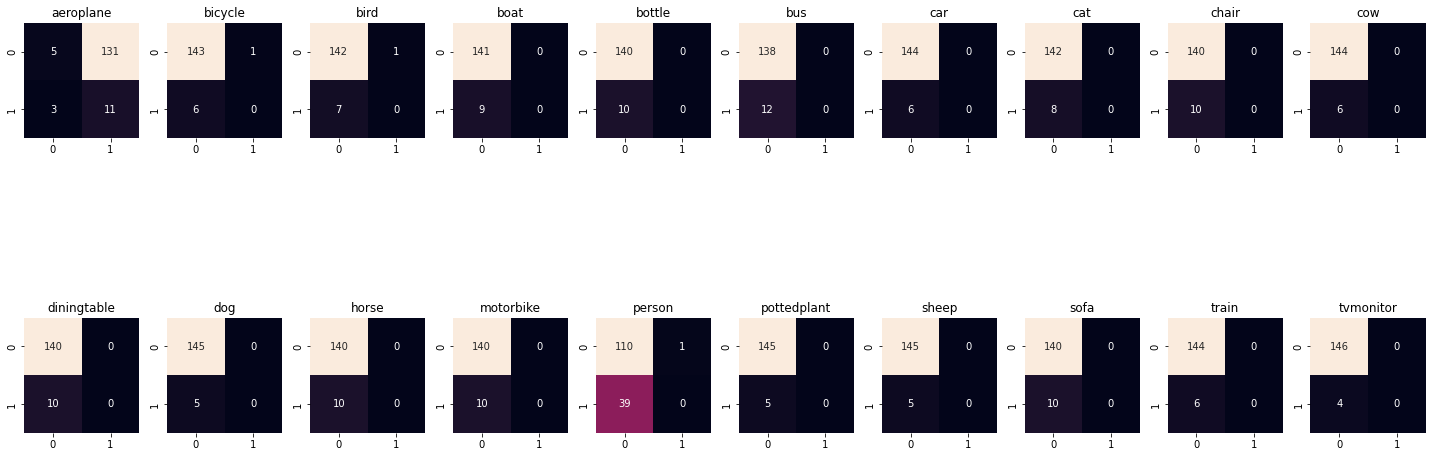

In [133]:
noise_val = attacker.return_noise(x_val)
y_val = classifier.predict(x_val)
y_val = y_val.round()
adv_val = classifier.predict(x_val + noise_val)
adv_val = noisy_predictions.round()

CM = multilabel_confusion_matrix(y_val, adv_val)

labels = yCat_test.columns

fig = plt.figure(figsize=(20,10))
ax = fig.subplots(2,10)
ax = ax.flatten()
for l,c,a in zip(labels,CM,ax):
    sns.heatmap(c, annot=True,ax=a,cbar=False,fmt="g") # font size\
    a.set_title(l)
    a.set_aspect('equal', 'box')

plt.tight_layout()

The following indicates that only in four cases in the validation set the classifier was able to tell the image was not an aeroplane. In all other cases the classifier was fooled by the adversary.

# General discussion
### Data augmentation

In future work we would like to also include random-erasing and mixing-images. Further tuning of the data augmentation parameters could also be performed.

### Classification

For the classification model it was hard to know what the upper bound was on the performance we could get. From visualizing certain images it was clear that there were ones we would have misclassified ourselves. This essentially means that it was very hard to know when to stop tuning and when there was still a lot of margin. Looking at the leaderboard it is clear that there is room to improve, but it is hard to know exactly what we could have done better - we tried extensive hyperparameter search, different pretrained architectures and training different models from scratch.

### Segmentation

Regarding segmentation, the biggest take-home message is to use data augmentation. Prior to doing it, our models were hardly training anything or simply classifying all pixels as background. We could not improve model performance even by changing the model structure, optimization or loss estimation. As soon as we started increasing the amount of training data produced by augmentations, our models started learning the segmentation of the objects, achieving the overall performance of almost 90% pixel-wise accuracy on the data unseen during training. Moreover, we conclude that training the model from scratch was too hard of a problem for such a small amount of training data. Therefore, transfer-learning model outperformed the from-scratch-model by light years.

### Adversary

We feel that our adversary has reached its goal. The noise could have been less, however we did not spend time optimizing either the $\lambda$ parameter as well as considering an optimiser with a different learning rate. Both would have produced images with less noise. We focused on experimenting with a method that was inspired by other approaches rather than copying an existing approach and we feel satisfied with the results. 

We also believe the threat of adversarial attacks might be realistic considering practitioners frequently fine-tune existing Resnet of Xception models. This means that an attack designed for one pre-trained model might work on several, however this would require further research. **Using adversarial examples and labeling them correctly would be a way to make these  models more robust to these attacks.**
